In [1]:
# !pip install pandas numpy matplotlib tensorflow scikit-learn stable-baselines3
# !pip install gymnasium
# !pip install python-binance

# 1. Introduction

(This section would be written text, outlining the growing interest in applying RL to finance, the challenges of financial markets (non-stationarity, noise), and how this project aims to explore specific RL algorithms beyond simple Q-learning for a more nuanced trading approach.)

**Motivation:** Financial markets, particularly cryptocurrency markets, exhibit complex dynamics that are challenging for traditional trading strategies. Reinforcement Learning (RL) offers a promising paradigm by enabling an agent to learn optimal trading policies through direct interaction with the market environment.

**Objectives:**

* Implement a robust data pipeline for acquiring historical cryptocurrency price data.
* Design and implement a flexible trading environment.
* Experiment with and compare the performance of Policy Gradient (REINFORCE) and Actor-Critic (A2C) algorithms.
* Investigate the impact of different reward designs and trading constraints on agent performance.

**Project Scope:** This project focuses on minute-resolution BTCUSDT data from Binance. The RL agents will learn to make discrete trading decisions (buy, sell, hold).

---


This Python script downloads, processes, and splits historical cryptocurrency data (e.g., BTC/USDT) from Binance using the Binance API. 

In [ ]:
import pandas as pd
from binance.client import Client
from datetime import datetime, timedelta
import os
import numpy as np
import matplotlib.pyplot as plt

# --- Configuration ---
API_KEY = ""  # 
API_SECRET = ""
TICKERS = ["BTCUSDT"]
INTERVAL = Client.KLINE_INTERVAL_1HOUR
# INTERVAL = Client.KLINE_INTERVAL_15MINUTE
LOOKBACK_MINUTES = 36000 * 2   # Approx 50 days of minute data, let's increase for train/test split
DATA_FILENAME = f"binance_data_{TICKERS[0]}_{INTERVAL}_{LOOKBACK_MINUTES}m.csv"

# Initialize Binance API client
# Initializes Binance client only if credentials are provided.
# Falls back to loading data from file if credentials are missing.
if API_KEY and API_SECRET:
    client = Client(API_KEY, API_SECRET)
else:
    print("Warning: API Key and Secret not provided. Will attempt to load data from file.")
    client = None

# --- Data Acquisition ---
# Downloads historical candlestick data for a single symbol from Binance
def fetch_kline_data_single(symbol, interval, start_date_str):
    """Fetches historical kline data for a single symbol."""
    print(f"Fetching {symbol} data from {start_date_str} at {interval} interval...")
    try:
        klines = client.get_historical_klines(symbol, interval, start_date_str)
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")
        return pd.DataFrame()

    df = pd.DataFrame(klines, columns=[
        "timestamp", "open", "high", "low", "close", "volume",
        "close_time", "quote_asset_volume", "number_of_trades",
        "taker_buy_base", "taker_buy_quote", "ignore"])

    df["Date"] = pd.to_datetime(df["timestamp"], unit='ms')
    # Select and type cast relevant columns
    for col in ["open", "high", "low", "close", "volume"]:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Keep only necessary columns for this exercise
    return df[["Date", "open", "high", "low", "close", "volume"]].rename(
        columns={col: f"{symbol}_{col}" for col in ["open", "high", "low", "close", "volume"]}
    )

# If data is already saved as a CSV file, it loads it.
# Otherwise, fetches data using the above function.
def download_and_prepare_data(tickers, interval, lookback_minutes, filename):
    """Downloads data if not present, or loads from file."""
    if os.path.exists(filename):
        print(f"Loading data from {filename}...")
        final_df = pd.read_csv(filename, parse_dates=['Date'])
        # Ensure 'Date' is timezone-naive for consistency if it was saved with tz
        if final_df['Date'].dt.tz is not None:
            final_df['Date'] = final_df['Date'].dt.tz_localize(None)
        return final_df

    if not client:
        print("Binance client not initialized and data file not found. Cannot proceed.")
        return pd.DataFrame()

    start_date_dt = datetime.utcnow() - timedelta(minutes=lookback_minutes)
    start_date_str = start_date_dt.strftime("%Y-%m-%d %H:%M:%S")

    all_dataframes = []
    for ticker in tickers:
        df_ticker = fetch_kline_data_single(ticker, interval, start_date_str)
        if not df_ticker.empty:
            all_dataframes.append(df_ticker)
        else:
            print(f"No data fetched for {ticker}. Skipping.")

    if not all_dataframes:
        print("No data could be fetched for any ticker.")
        return pd.DataFrame()

    # Assuming single ticker for simplicity in RL environment for now
    # If multiple, merging strategy would be important
    final_df = all_dataframes[0] # For single ticker
    # If multiple tickers were used:
    # final_df = all_dataframes[0]
    # for i in range(1, len(all_dataframes)):
    #     final_df = pd.merge(final_df, all_dataframes[i], on="Date", how="outer")

    final_df = final_df.sort_values(by="Date").reset_index(drop=True)
    final_df.dropna(inplace=True) # Drop rows with any NaNs from merge or data issues

    # Ensure 'Date' is timezone-naive before saving
    if final_df['Date'].dt.tz is not None:
            final_df['Date'] = final_df['Date'].dt.tz_localize(None)

    final_df.to_csv(filename, index=False)
    print(f"Data saved to {filename}")
    return final_df

# --- Execute Data Download/Load ---
# For BTCUSDT, column names will be BTCUSDT_close, BTCUSDT_open etc.
raw_data = download_and_prepare_data(TICKERS, INTERVAL, LOOKBACK_MINUTES, DATA_FILENAME)

if not raw_data.empty:
    print("\nData Sample:")
    print(raw_data.head())
    print(f"\nData Shape: {raw_data.shape}")
    # For this project, we primarily need the closing price of the first ticker
    # Let's assume TICKERS[0] is our target asset
    price_series = raw_data[f'{TICKERS[0]}_close'].copy()
else:
    print("Failed to load or download data. Exiting.")
    exit()

# --- Data Cleaning and Preparation (Minimal for this example) ---
# The download function already handles NaN removal.
# For RL, we often normalize data.

# --- Train-Validation-Test Split ---
# Crucial for evaluating generalization
total_len = len(price_series)
train_split_ratio = 0.7
val_split_ratio = 0.15
# test_split_ratio = 0.15 # Remainder

train_idx_end = int(total_len * train_split_ratio)
val_idx_end = int(total_len * (train_split_ratio + val_split_ratio))

train_data = price_series[:train_idx_end]
val_data = price_series[train_idx_end:val_idx_end]
test_data = price_series[val_idx_end:]

print(f"\nData Split:")
print(f"Train data length: {len(train_data)}")
print(f"Validation data length: {len(val_data)}")
print(f"Test data length: {len(test_data)}")



Loading data from binance_data_BTCUSDT_1h_72000m.csv...

Data Sample:
                 Date  BTCUSDT_open  BTCUSDT_high  BTCUSDT_low  BTCUSDT_close  \
0 2025-03-22 09:00:00      84222.01      84539.17     84222.01       84360.01   
1 2025-03-22 10:00:00      84360.01      84440.00     84360.00       84413.62   
2 2025-03-22 11:00:00      84413.63      84419.80     84204.68       84239.25   
3 2025-03-22 12:00:00      84239.24      84296.39     84176.49       84232.39   
4 2025-03-22 13:00:00      84232.40      84242.30     84040.99       84168.31   

   BTCUSDT_volume  
0       322.33818  
1       127.10886  
2       198.34352  
3       218.30063  
4       255.74960  

Data Shape: (1200, 6)

Data Split:
Train data length: 840
Validation data length: 180
Test data length: 180


## Commentary on Data:

* The code attempts to load data from a CSV if it exists, saving API calls.
* It's configured for a single ticker for simplicity in the RL environment setup, but the download function can handle multiple.
* A **train/validation/test split** is essential. The agent trains on `train_data`, hyperparameters might be tuned on `val_data` (though full hyperparameter optimization is out of scope for one assignment), and final unbiased performance is on `test_data`.

---

# 3. Reinforcement Learning Environment Design

We'll use `gymnasium` (the maintained fork of OpenAI Gym) to create a custom environment.

This Python code defines a custom reinforcement learning environment for trading, built using the gymnasium library (a modern fork of OpenAI Gym). It simulates a basic trading strategy over a price series (typically a list or pandas Series of asset prices). 

The TradingEnv class is a simulation environment that:

> Lets an agent learn to trade an asset using historical price data.

> Supports Buy, Sell, and Hold actions.

> Tracks portfolio metrics like balance, shares held, and net worth.

> Computes rewards based on profit or log returns.

> Optionally prevents trading during periods of high volatility (risk control).

> Is designed to work with reinforcement learning algorithms.

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np


class TradingEnv(gym.Env): 
    metadata = {'render_modes': ['human'], 'render_fps': 30}

    def __init__(self, price_data, window_size=10, initial_balance=1000000,
                 transaction_cost_pct=0.001, reward_type='profit',
                 constraint_type=None,
                 volatility_lookback=20,
                 volatility_threshold_pct=0.02,
                 DEBUG_MODE=False): # Added DEBUG_MODE flag
        super(TradingEnv, self).__init__()

        if not hasattr(price_data, 'values'):
            raise TypeError("Input 'price_data' is expected to be a pandas Series or similar object with a .values attribute.")
        self.price_data = price_data.values

        self.window_size = window_size
        self.initial_balance = float(initial_balance)
        self.transaction_cost_pct = float(transaction_cost_pct)
        self.reward_type = reward_type
        self.constraint_type = constraint_type
        self.volatility_lookback = int(volatility_lookback)
        self.volatility_threshold_pct = float(volatility_threshold_pct)
        self.DEBUG_MODE = DEBUG_MODE # Store debug flag

        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(window_size,), dtype=np.float32
        )
        self.action_space = spaces.Discrete(3)
        self._reset_state()

    def _reset_state(self):
        self.current_step = self.window_size
        self.balance = self.initial_balance
        self.shares_held = 0.0
        self.net_worth = self.initial_balance
        self.prev_net_worth = self.initial_balance
        self.trade_history = []
        self.long_entry_price = 0.0
        if self.DEBUG_MODE: print(f"--- ENV RESET --- Initial Balance: {self.balance}")

    # Resets environment to initial state.
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self._reset_state()
        return self._get_observation(), self._get_info()

    # Returns a normalized price window from current step.
    # Normalized to the first price in the window.
    def _get_observation(self):
        obs_start_idx = self.current_step - self.window_size
        obs_end_idx = self.current_step
        if obs_start_idx < 0: return np.zeros(self.window_size, dtype=np.float32)
        price_segment = self.price_data[obs_start_idx:obs_end_idx]
        if len(price_segment) != self.window_size: return np.zeros(self.window_size, dtype=np.float32)
        if price_segment[0] == 0: return np.zeros(self.window_size, dtype=np.float32)
        normalized_prices = price_segment / (price_segment[0] + 1e-9)
        return normalized_prices.astype(np.float32)

    def _get_info(self):
        price_for_info = 0.0
        # Ensure current_step is within bounds for self.price_data
        if 0 <= self.current_step < len(self.price_data):
            price_for_info = self.price_data[self.current_step]
        elif len(self.price_data) > 0 : # If current_step is at the very end due to termination
            price_for_info = self.price_data[-1] # Use last available price
        return {
            "net_worth": self.net_worth, "balance": self.balance,
            "shares_held": self.shares_held, "current_price": price_for_info
        }

    # Blocks trading if recent volatility exceeds a threshold (if enabled).
    # Volatility is calculated using the standard deviation of log returns over a recent window.
    def _is_trade_allowed(self):
        if self.constraint_type == 'no_trade_high_volatility':
            if self.current_step < self.volatility_lookback: return True
            vol_start_idx = self.current_step - self.volatility_lookback
            vol_end_idx = self.current_step
            price_segment_for_vol = self.price_data[vol_start_idx:vol_end_idx]
            if len(price_segment_for_vol) < 2: return True
            positive_prices = price_segment_for_vol[price_segment_for_vol > 0]
            if len(positive_prices) < 2: return True
            log_returns_vol = np.diff(np.log(positive_prices))
            if len(log_returns_vol) < 1: return True
            current_volatility = np.std(log_returns_vol)
            if current_volatility > self.volatility_threshold_pct:
                if self.DEBUG_MODE: print(f"    DEBUG: High volatility ({current_volatility:.4f}), trade BLOCKED.")
                return False
        return True

    # Based on the change in net worth or log return.
    # Small penalty for inactivity with no position (to encourage engagement).
    def _calculate_reward(self, action_performed):
        # Ensure current_step is valid for price_data access
        if not (0 <= self.current_step < len(self.price_data)):
            if self.DEBUG_MODE: print(f"    DEBUG_REWARD: current_step {self.current_step} out of bounds for price_data (len {len(self.price_data)}). Using last known net_worth for reward.")
            # If out of bounds, net_worth might not have been updated with a new price.
            # This scenario should ideally be prevented by termination logic.
            # Here, we assume net_worth and prev_net_worth are already set correctly from last valid step.
            # Or, if liquidation happened, net_worth is final balance.
        else:
            current_decision_price = self.price_data[self.current_step]
            self.net_worth = self.balance + self.shares_held * current_decision_price

        reward = 0.0
        if self.reward_type == 'profit':
            reward = self.net_worth - self.prev_net_worth
            if not action_performed and self.shares_held == 0: reward -= self.initial_balance * 0.000001
        elif self.reward_type == 'log_return':
            if self.prev_net_worth > 0 and self.net_worth > 0:
                reward = np.log(self.net_worth / self.prev_net_worth)
            elif self.net_worth <= 0 < self.prev_net_worth: reward = -1.0
            else: reward = 0.0
            if not action_performed and self.shares_held == 0: reward -= 0.00001
        
        if self.DEBUG_MODE and self.reward_type == 'profit':
            print(f"    DEBUG_REWARD (profit): NW: {self.net_worth:.2f}, PrevNW: {self.prev_net_worth:.2f}, RawProfit: {self.net_worth - self.prev_net_worth:.2f}, FinalReward: {reward:.5f}")
        elif self.DEBUG_MODE and self.reward_type == 'log_return':
            print(f"    DEBUG_REWARD (log_ret): NW: {self.net_worth:.2f}, PrevNW: {self.prev_net_worth:.2f}, Log(NW/PrevNW): {np.log(self.net_worth / self.prev_net_worth) if self.prev_net_worth > 0 and self.net_worth > 0 else 'N/A'}, FinalReward: {reward:.5f}")

        self.prev_net_worth = self.net_worth
        return reward

    # Takes an action (Hold, Buy, Sell) and performs it if allowed.
    def step(self, action):
        if self.DEBUG_MODE:
            print(f"\nDEBUG_STEP Start: current_step={self.current_step}, action={action}, balance={self.balance:.2f}, shares={self.shares_held:.4f}, prev_nw={self.prev_net_worth:.2f}")

        # Boundary check for current_step before accessing price_data
        if not (0 <= self.current_step < len(self.price_data)):
            # This means we've already reached termination in a previous step or an error occurred.
            # Should return immediately with current state if already terminated.
            if self.DEBUG_MODE: print(f"DEBUG_STEP: current_step {self.current_step} is out of bounds. Returning zeros/last state.")
            obs = np.zeros(self.window_size, dtype=np.float32) # Default observation
            info = self._get_info() # Get current info
            # If shares held, assume they were liquidated and net_worth = balance
            # This part of logic might need refinement if step is called *after* true termination.
            return obs, 0.0, True, False, info # Reward 0, terminated True

        current_execution_price = self.price_data[self.current_step]
        action_performed_transaction = False
        if self.DEBUG_MODE: print(f"    DEBUG_STEP: current_execution_price={current_execution_price:.2f}")

        trade_allowed_by_constraint = self._is_trade_allowed()
        if self.DEBUG_MODE: print(f"    DEBUG_STEP: trade_allowed_by_constraint={trade_allowed_by_constraint}")

        if trade_allowed_by_constraint:
            if action == 1: # Buy
                if self.DEBUG_MODE: print(f"    DEBUG_STEP: Attempting BUY. Shares held: {self.shares_held}")
                if self.shares_held == 0:
                    cost_per_share = current_execution_price * (1 + self.transaction_cost_pct)
                    if self.DEBUG_MODE: print(f"        DEBUG_BUY: cost_per_share={cost_per_share:.2f}, balance={self.balance:.2f}")
                    if self.balance >= cost_per_share and cost_per_share > 0:
                        shares_to_buy = self.balance / cost_per_share
                        self.shares_held = shares_to_buy
                        self.balance = 0.0
                        self.long_entry_price = current_execution_price
                        self.trade_history.append({'step': self.current_step, 'type': 'BUY',
                                                   'price': current_execution_price, 'shares': self.shares_held})
                        action_performed_transaction = True
                        if self.DEBUG_MODE: print(f"        DEBUG_BUY: SUCCESS! Shares bought: {self.shares_held:.4f}")
                    elif self.DEBUG_MODE:
                        print(f"        DEBUG_BUY: FAILED. Condition: balance ({self.balance:.2f}) >= cost_per_share ({cost_per_share:.2f}) AND cost_per_share > 0. Met: {self.balance >= cost_per_share and cost_per_share > 0}")
                elif self.DEBUG_MODE: print(f"        DEBUG_BUY: FAILED. Already holding shares.")
            elif action == 2: # Sell
                if self.DEBUG_MODE: print(f"    DEBUG_STEP: Attempting SELL. Shares held: {self.shares_held}")
                if self.shares_held > 0:
                    sell_value = self.shares_held * current_execution_price
                    transaction_fee = sell_value * self.transaction_cost_pct
                    self.balance += sell_value - transaction_fee
                    self.shares_held = 0.0
                    self.long_entry_price = 0.0
                    self.trade_history.append({'step': self.current_step, 'type': 'SELL',
                                               'price': current_execution_price, 'value': sell_value - transaction_fee})
                    action_performed_transaction = True
                    if self.DEBUG_MODE: print(f"        DEBUG_SELL: SUCCESS! Sold shares. New balance: {self.balance:.2f}")
                elif self.DEBUG_MODE: print(f"        DEBUG_SELL: FAILED. No shares to sell.")
        elif self.DEBUG_MODE:
            print(f"    DEBUG_STEP: Trade attempt (action {action}) was blocked by constraint.")


        if self.DEBUG_MODE: print(f"    DEBUG_STEP: action_performed_transaction={action_performed_transaction}")
        reward = self._calculate_reward(action_performed_transaction) # prev_net_worth is from before this step's action

        self.current_step += 1

        terminated = self.current_step >= len(self.price_data) - 1
        truncated = False
        
        if self.DEBUG_MODE: print(f"    DEBUG_STEP End: next_current_step={self.current_step}, terminated={terminated}, reward={reward:.5f}")


        observation = self._get_observation()
        info = self._get_info() # This info is for s_t+1

        if terminated and self.shares_held > 0:
            if self.DEBUG_MODE: print(f"    DEBUG_TERMINATION: Liquidating {self.shares_held:.4f} shares.")
            last_price_for_liquidation = self.price_data[len(self.price_data) - 1]
            if self.DEBUG_MODE: print(f"        DEBUG_LIQUIDATE: Price {last_price_for_liquidation:.2f}")
            sell_value = self.shares_held * last_price_for_liquidation
            transaction_fee = sell_value * self.transaction_cost_pct
            self.balance += sell_value - transaction_fee
            self.shares_held = 0.0
            self.net_worth = self.balance
            info = self._get_info() # Update info after liquidation
            if self.DEBUG_MODE: print(f"        DEBUG_LIQUIDATE: Final Balance: {self.balance:.2f}, Final NW: {self.net_worth:.2f}")
            # The reward for the last action does not include this liquidation value by default.
            # The final state's net_worth reflects it.

        return observation, reward, terminated, truncated, info

    def render(self):
        step_to_render = self.current_step -1 if self.current_step > self.window_size else self.current_step
        print(f"Render after step {step_to_render}: Net Worth: {self.net_worth:.2f}, Shares: {self.shares_held:.4f}, Balance: {self.balance:.2f}")

# Commentary on Environment and Reinforcement Learning Setup

## Environment Details

* **State Space:** A window of past prices (normalized to the start of the window). Position status (long/flat) is implicitly part of the agent's learned policy based on this history or can be explicitly added. Current implementation simplifies state to just normalized prices.
* **Action Space:** Discrete: Buy, Sell, Hold.
    * **Buy:** Go all-in from flat.
    * **Sell:** Liquidate long position to flat.
    * **Hold:** Do nothing.

## Reward Design

* **'profit':** Change in `net_worth` per step. Simple but can be noisy.
* **'log_return':** Log of (`current_net_worth` / `previous_net_worth`). More stable, often preferred in finance.
* **'sharpe' (Simplified):** Currently maps to 'profit'. True Sharpe ratio is an episode-level metric (total return / std dev of returns). To use it as a step-wise reward, you'd need approximations like rewarding positive returns and penalizing variance, or using a running Sharpe.

## Constraints

* **Transaction Costs:** `transaction_cost_pct` is applied on buys and sells.
* **No Short Selling:** Agent can only be long or flat.
* **No Leverage:** Agent uses available balance.
* **Episode Termination:** When all price data for the current segment (train/val/test) is consumed. Open positions are liquidated at the end.

## Reinforcement Learning Algorithm Exploration

We'll use TensorFlow/Keras to build the neural networks for **REINFORCE** and **A2C**.

Common Neural Network Building Blocks (Details would follow here)

This code defines two neural network models using TensorFlow/Keras — one for policy (action selection) and one for value estimation — typically used in actor-critic reinforcement learning algorithms (like A2C, PPO, etc.).

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Creates a neural network that outputs a probability distribution over actions — i.e., the policy π(a|s).
# input_shape: shape of the environment observation (e.g., (10,) for 10 features).
# num_actions: number of discrete actions (e.g., 3 for buy/sell/hold).
# hidden_units: list defining hidden layer sizes (default: [64, 32]).
def create_policy_network(input_shape, num_actions, hidden_units=[64, 32]):
    """Creates a policy network (outputs action probabilities)."""
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs
    for units in hidden_units:
        x = layers.Dense(units, activation="relu")(x)
    outputs = layers.Dense(num_actions, activation="softmax")(x) # Probabilities for each action
    return tf.keras.Model(inputs=inputs, outputs=outputs)

# Creates a neural network that outputs a scalar value estimate of a state — i.e., the value function V(s).
def create_value_network(input_shape, hidden_units=[64, 32]):
    """Creates a value network (outputs state value)."""
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs
    for units in hidden_units:
        x = layers.Dense(units, activation="relu")(x)
    outputs = layers.Dense(1)(x) # Single value output
    return tf.keras.Model(inputs=inputs, outputs=outputs)


2025-05-12 10:52:33.912468: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-12 10:52:33.943072: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-12 10:52:33.943602: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-12 10:52:34.558412: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 4.2. Policy Network: **REINFORCE** (Monte Carlo Policy Gradient)

### Theoretical Background:

**REINFORCE** updates the policy network parameters $\theta$ by ascending the gradient of the expected total discounted reward:

$$ \nabla_\theta J(\theta) = \mathbb{E}_\tau \left[ \sum_t (\nabla_\theta \log \pi_\theta(a_t|s_t)) \cdot G_t \right] $$

where $\pi_\theta$ is the policy, $a_t$ is action, $s_t$ is state, and $G_t$ is the discounted return from step $t$ onwards.

### Implementation Details:

This code defines a REINFORCE agent using TensorFlow/Keras. REINFORCE is a classic policy gradient method in reinforcement learning, where the policy is directly optimized using the return of sampled episodes.

In [ ]:
class REINFORCEAgent:
    # Initializes the agent's key parameters:
    # state_dim: input dimension of the environment's state.
    # action_dim: number of possible actions.
    # learning_rate: for the Adam optimizer.
    # gamma: discount factor for future rewards (closer to 1 means long-term rewards matter more).
    def __init__(self, state_dim, action_dim, learning_rate=0.001, gamma=0.99):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma # Discount factor

        self.policy_network = create_policy_network(state_dim, action_dim)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

        self.trajectory_states = []
        self.trajectory_actions = []
        self.trajectory_rewards = []

    # Takes a state and returns an action sampled from the policy's output probabilities.
    # state is converted to a batch of 1.
    # Uses np.random.choice() to sample an action based on the softmax probabilities output by the policy network.
    def select_action(self, state):
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        action_probs = self.policy_network(state)[0].numpy() # Get probs for the single state
        action = np.random.choice(self.action_dim, p=action_probs)
        return action

    # Stores the current step’s (state, action, reward) into lists for use after the episode ends.
    def store_transition(self, state, action, reward):
        self.trajectory_states.append(state)
        self.trajectory_actions.append(action)
        self.trajectory_rewards.append(reward)

    # Computes the discounted return for each timestep.
    # Returns an array of discounted returns — one per time step.
    # Optionally normalizes the returns (commented out), which can reduce variance in training.
    def _calculate_discounted_returns(self):
        discounted_returns = np.zeros_like(self.trajectory_rewards, dtype=np.float32)
        running_add = 0
        for t in reversed(range(len(self.trajectory_rewards))):
            running_add = self.trajectory_rewards[t] + self.gamma * running_add
            discounted_returns[t] = running_add
        
        # Normalize returns (optional but often helpful for stability)
        # discounted_returns = (discounted_returns - np.mean(discounted_returns)) / (np.std(discounted_returns) + 1e-9)
        return discounted_returns

    # This is the core learning step, applied after an episode finishes.
    # Converts the stored states/actions/returns to tensors.
    # Computes action probabilities from the policy.
    # Uses tf.gather_nd() to extract the probabilities of the actions that were actually taken.
    # The loss is the negative log-probability of chosen actions weighted by returns:
    def update(self):
        if not self.trajectory_rewards:
            return 0.0 # No updates if trajectory is empty

        discounted_returns = self._calculate_discounted_returns()
        
        states_tensor = tf.convert_to_tensor(self.trajectory_states, dtype=tf.float32)
        actions_tensor = tf.convert_to_tensor(self.trajectory_actions, dtype=tf.int32)
        returns_tensor = tf.convert_to_tensor(discounted_returns, dtype=tf.float32)

        with tf.GradientTape() as tape:
            action_probs = self.policy_network(states_tensor)
            # Get probabilities of chosen actions: tf.gather_nd extracts these
            # Create indices for gather_nd: [[0, action0], [1, action1], ...]
            indices = tf.stack([tf.range(tf.shape(actions_tensor)[0]), actions_tensor], axis=1)
            chosen_action_probs = tf.gather_nd(action_probs, indices)

            # Loss: -log_prob * G_t (negative because optimizer minimizes)
            # Adding a small epsilon for numerical stability with log
            loss = -tf.reduce_sum(tf.math.log(chosen_action_probs + 1e-9) * returns_tensor)
        
        grads = tape.gradient(loss, self.policy_network.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.policy_network.trainable_variables))

        # Clear trajectory for next episode
        self.trajectory_states = []
        self.trajectory_actions = []
        self.trajectory_rewards = []
        
        return loss.numpy()


## 4.3. Actor-Critic Network: **Advantage Actor-Critic (A2C)**

### Theoretical Background:

**A2C** uses two networks: an **Actor** (policy) and a **Critic** (value function).

* **Actor:** $\pi_\theta(a|s)$, learns what action to take.
* **Critic:** $V_\phi(s)$, learns how good a state is.

The gradient for the **Actor** is:
$$ \nabla_\theta J(\theta) = \mathbb{E} \left[ \sum_t (\nabla_\theta \log \pi_\theta(a_t|s_t)) \cdot A(s_t, a_t) \right] $$
where $A(s_t, a_t) = Q(s_t, a_t) - V_\phi(s_t)$ is the advantage function.

Commonly, the advantage function is approximated using the TD error:
$$ A(s_t, a_t) \approx r_t + \gamma V_\phi(s_{t+1}) - V_\phi(s_t) $$

### Implementation Details:

This code defines an A2C (Advantage Actor-Critic) agent using TensorFlow/Keras. A2C is a synchronous and simplified variant of the Actor-Critic family, where the actor learns a policy and the critic learns a value function. Both are trained from the same experience.

In [ ]:
class A2CAgent:
    # state_dim: Input dimensionality of the state space.
    # action_dim: Number of possible discrete actions.
    # gamma: Discount factor for future rewards.
    # Initializes:
    # self.actor: Policy network — outputs action probabilities (via softmax).
    # self.critic: Value network — estimates state value  V(s).
    # Two optimizers: one for the actor, one for the critic.
    def __init__(self, state_dim, action_dim, actor_lr=0.0005, critic_lr=0.001, gamma=0.99):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma

        self.actor = create_policy_network(state_dim, action_dim)
        self.critic = create_value_network(state_dim)
        self.actor_optimizer = tf.keras.optimizers.Adam(learning_rate=actor_lr)
        self.critic_optimizer = tf.keras.optimizers.Adam(learning_rate=critic_lr)

    # Converts a state into a batch of 1.
    # Uses the actor (policy network) to get action probabilities.
    # Samples an action according to these probabilities (stochastic policy).
    def select_action(self, state):
        state_tensor = tf.convert_to_tensor([state], dtype=tf.float32)
        action_probs = self.actor(state_tensor)[0].numpy()
        action = np.random.choice(self.action_dim, p=action_probs)
        return action

    # This method performs one-step actor-critic update using a single transition
    def update(self, state, action, reward, next_state, done):
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        next_state = tf.convert_to_tensor([next_state], dtype=tf.float32)
        reward = tf.convert_to_tensor(reward, dtype=tf.float32)
        action = tf.convert_to_tensor(action, dtype=tf.int32) # Single action

        with tf.GradientTape() as actor_tape, tf.GradientTape() as critic_tape:
            # Critic loss
            current_v = self.critic(state)[0,0] # Get scalar value
            next_v = self.critic(next_state)[0,0] if not done else tf.constant(0.0, dtype=tf.float32)
            target_v = reward + self.gamma * next_v
            advantage = target_v - current_v # This is TD_error, also the advantage A(s,a)
            critic_loss = tf.square(advantage) # MSE loss for critic

            # Actor loss
            action_probs = self.actor(state)
            # We need log_prob of the specific action taken
            # action is a scalar, need to make it indexable for gather_nd
            # For a single transition:
            chosen_action_prob = action_probs[0, action]
            
            # Actor loss: -log_prob * advantage (negative for minimization)
            # Use tf.stop_gradient on advantage as it's treated as a constant for actor update
            actor_loss = -tf.math.log(chosen_action_prob + 1e-9) * tf.stop_gradient(advantage)

        # Two GradientTape blocks allow independent tracking of gradients for actor and critic.
        # Applies gradients using the respective optimizers.
        actor_grads = actor_tape.gradient(actor_loss, self.actor.trainable_variables)
        critic_grads = critic_tape.gradient(critic_loss, self.critic.trainable_variables)

        self.actor_optimizer.apply_gradients(zip(actor_grads, self.actor.trainable_variables))
        self.critic_optimizer.apply_gradients(zip(critic_grads, self.critic.trainable_variables))
        
        return actor_loss.numpy(), critic_loss.numpy()


## 5. Experimental Setup and Training
## Commentary on Training:

* **REINFORCE** updates at the end of each episode (Monte Carlo).
* **A2C** updates at each step (Temporal Difference).
* **Validation set** performance is checked periodically. This helps monitor overfitting and gives an idea of generalization.
* The number of episodes (`N_EPISODES_*`) is small for quick demonstration. Real training would require significantly more.
* **Learning Rates** & **Gamma**: These are crucial hyperparameters. **Gamma** (discount factor) close to 1 for financial tasks is common, as future rewards are important. **Learning rates** need tuning.
* **State Representation**: Using `WINDOW_SIZE` normalized prices is a common starting point. More features (volume, indicators) could be added.

## 6. Results and Analysis

This section involves running the agents on the `test_data` and comparing:

* **Final Net Worth:** Absolute performance.
* **Cumulative Reward Plot:** Visualizing how reward accumulates.
* **Sharpe Ratio:** Risk-adjusted return (Total Return / StdDev of Returns).
* **Max Drawdown:** Largest peak-to-trough decline.
* **Number of Trades:** To understand trading frequency.

This code defines and executes Stage 1 of a reinforcement learning experiment involving financial trading. It compares two policy-gradient algorithms — REINFORCE and A2C (Advantage Actor-Critic) — across two different reward types: profit and log_return. Here's a breakdown of what's happening:

--- Stage 1: Training A2C & REINFORCE with different reward functions ---

--- Training: REINFORCE_ProfitReward ---


2025-05-12 10:52:35.312854: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


REINFORCE_ProfitReward - Ep 10/200, Train Rew: -44097.8156, Loss: -3090478.0000, Val NW: 986576.06
REINFORCE_ProfitReward - Ep 20/200, Train Rew: -27632.3160, Loss: -1069336.6250, Val NW: 969401.04
REINFORCE_ProfitReward - Ep 30/200, Train Rew: 142878.2242, Loss: 10497526.0000, Val NW: 983802.76
REINFORCE_ProfitReward - Ep 40/200, Train Rew: 34963.1851, Loss: 2505386.0000, Val NW: 999087.50
REINFORCE_ProfitReward - Ep 50/200, Train Rew: 18223.3498, Loss: 612384.8750, Val NW: 1022095.69
REINFORCE_ProfitReward - Ep 60/200, Train Rew: 128467.7741, Loss: 5781794.5000, Val NW: 1024370.71
REINFORCE_ProfitReward - Ep 70/200, Train Rew: 56321.0653, Loss: 1477876.8750, Val NW: 1024211.78
REINFORCE_ProfitReward - Ep 80/200, Train Rew: 42159.0547, Loss: 1048448.3750, Val NW: 1009343.34
REINFORCE_ProfitReward - Ep 90/200, Train Rew: 85158.8077, Loss: 2367870.7500, Val NW: 1022457.61
REINFORCE_ProfitReward - Ep 100/200, Train Rew: 65952.8787, Loss: 234859.9844, Val NW: 1011903.57
REINFORCE_ProfitRe

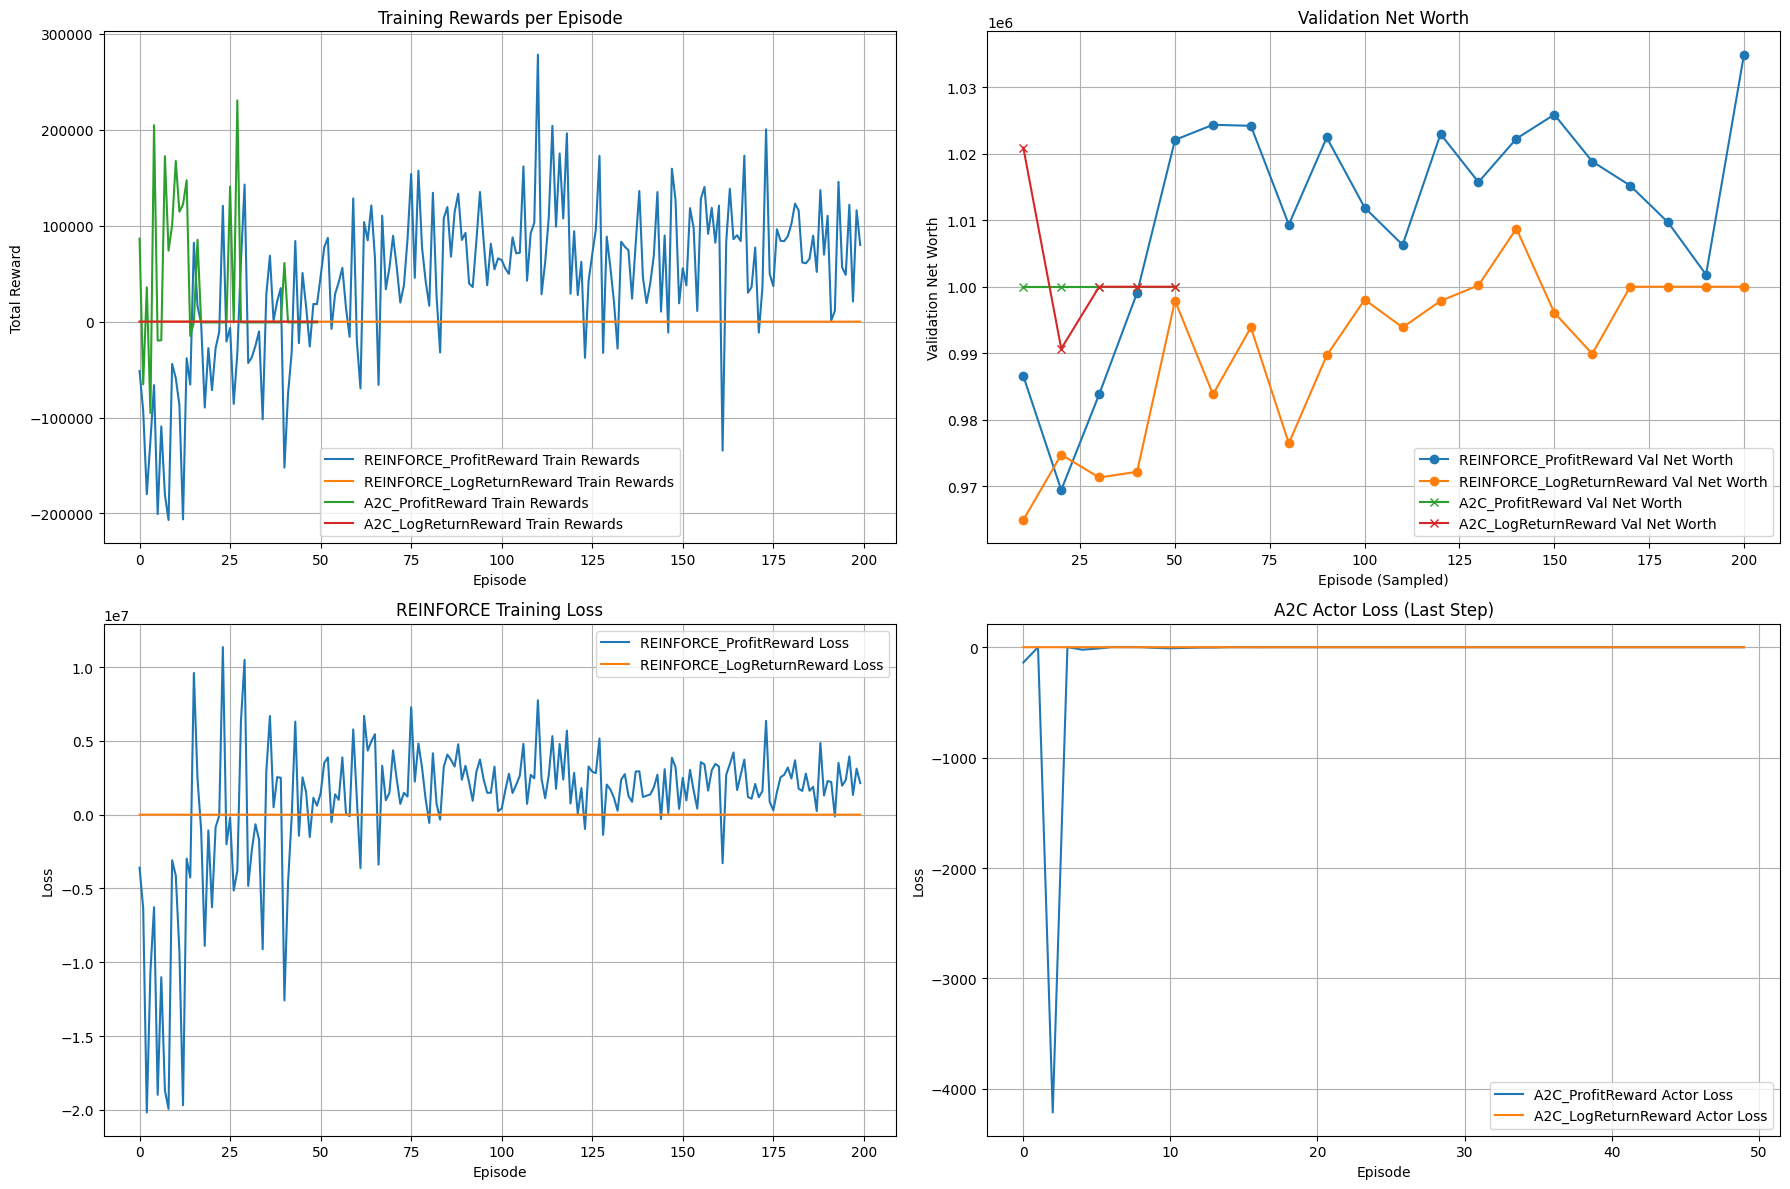


--- Stage 1 Evaluation ---

Evaluating REINFORCE_ProfitReward on Test Set...
REINFORCE_ProfitReward - Test Avg Reward: 92319.2635, Final Net Worth: 1096445.48

Evaluating REINFORCE_LogReturnReward on Test Set...
REINFORCE_LogReturnReward - Test Avg Reward: -0.0017, Final Net Worth: 999760.91

Evaluating A2C_ProfitReward on Test Set...
A2C_ProfitReward - Test Avg Reward: -149.0000, Final Net Worth: 1000000.00

Evaluating A2C_LogReturnReward on Test Set...
A2C_LogReturnReward - Test Avg Reward: -0.0015, Final Net Worth: 1000000.00

Stage 1 Test Summary:
               Experiment  Test Final Net Worth  Test Avg Reward
   REINFORCE_ProfitReward          1.096445e+06     92319.263455
REINFORCE_LogReturnReward          9.997609e+05        -0.001709
         A2C_ProfitReward          1.000000e+06      -149.000000
      A2C_LogReturnReward          1.000000e+06        -0.001490


In [ ]:
# REINFORCE needs more training due to high variance.
# A2C is more sample efficient (uses TD learning).
# WINDOW_SIZE: number of historical prices fed as state.
# TRANSACTION_COST: used in the TradingEnv to simulate realistic trading (fees).
N_EPISODES_REINFORCE = 200  # REINFORCE typically needs more episodes or longer ones
N_EPISODES_A2C = 50         # A2C can be more sample efficient per interaction
WINDOW_SIZE = 30            # Number of past price points in state
TRANSACTION_COST = 0.00075  # Binance VIP 0: 0.1% maker/taker. Let's use 0.075%


# # --- Helper for Evaluation ---
# Used during validation and final testing to evaluate trained agents:
# Runs the agent for num_episodes.
# Returns average episode rewards and average final net worths.
def evaluate_agent(env, agent, num_episodes=1):
    total_rewards = []
    final_net_worths = []
    for episode in range(num_episodes):
        obs, info = env.reset()
        done = False
        episode_reward = 0
        while not done:
            action = agent.select_action(obs) # For REINFORCE
            # For A2C, action selection is similar: agent.select_action(obs)
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            episode_reward += reward
        total_rewards.append(episode_reward)
        final_net_worths.append(info['net_worth'])
    return np.mean(total_rewards), np.mean(final_net_worths)


# --- Experiment Configurations for Stage 1 ---
# Each configuration defines:
# Which agent to use (REINFORCE or A2C).
# Which reward function to optimize (profit or log_return).
# Relevant hyperparameters (learning_rate, gamma, etc.).
stage1_configs = {
    "REINFORCE_ProfitReward": {
        "agent_type": "REINFORCE",
        "reward_type": "profit",
        "agent_params": {"learning_rate": 0.0005, "gamma": 0.99},
        "n_episodes": N_EPISODES_REINFORCE
    },
    "REINFORCE_LogReturnReward": {
        "agent_type": "REINFORCE",
        "reward_type": "log_return",
        "agent_params": {"learning_rate": 0.0005, "gamma": 0.99},
        "n_episodes": N_EPISODES_REINFORCE
    },
    "A2C_ProfitReward": {
        "agent_type": "A2C",
        "reward_type": "profit",
        "agent_params": {"actor_lr": 0.0001, "critic_lr": 0.0005, "gamma": 0.99},
        "n_episodes": N_EPISODES_A2C
    },
    "A2C_LogReturnReward": {
        "agent_type": "A2C",
        "reward_type": "log_return",
        "agent_params": {"actor_lr": 0.0001, "critic_lr": 0.0005, "gamma": 0.99},
        "n_episodes": N_EPISODES_A2C
    }
}

# Store trained agents and their training history
trained_agents_stage1 = {}
training_histories_stage1 = {}
last_train_episode_trades_stage1 = {} # <<<<<<< INITIALIZE HERE


print("--- Stage 1: Training A2C & REINFORCE with different reward functions ---")

# For each configuration:

# ✅ Environment Setup: Create training & validation environments using different reward schemes.
# ✅ Agent Setup:
# REINFORCEAgent or A2CAgent instantiated with proper hyperparameters.
# ✅ Episode Loop:
# Runs for n_episodes (depends on agent type).
# For each step:
# The agent selects an action.
# The environment returns a new observation and reward.
# The agent stores the transition and learns (either at episode end for REINFORCE or at each step for A2C).
# ✅ Training Metrics Tracking:
# episode_rewards_history: total rewards per episode.
# losses_history:
# scalar loss (REINFORCE).
# actor/critic loss dict (A2C).
# val_net_worths_history: validation performance, measured every 10 episodes.
# ✅ Final Trade Record Storage:
# On last training episode, saves trade history from that episode for later analysis.

for config_name, config in stage1_configs.items():
    print(f"\n--- Training: {config_name} ---")
    current_agent_type = config["agent_type"]
    current_reward_type = config["reward_type"]
    current_n_episodes = config["n_episodes"]

    # Instantiate Environment for this configuration
    train_env = TradingEnv(train_data, window_size=WINDOW_SIZE, reward_type=current_reward_type, transaction_cost_pct=TRANSACTION_COST, DEBUG_MODE=False)
    val_env = TradingEnv(val_data, window_size=WINDOW_SIZE, reward_type=current_reward_type, transaction_cost_pct=TRANSACTION_COST, DEBUG_MODE=False)

    # Instantiate Agent for this configuration
    agent = None
    if current_agent_type == "REINFORCE":
        agent = REINFORCEAgent(
            state_dim=(WINDOW_SIZE,), action_dim=train_env.action_space.n,
            learning_rate=config["agent_params"]["learning_rate"], gamma=config["agent_params"]["gamma"]
        )
    elif current_agent_type == "A2C":
        agent = A2CAgent(
            state_dim=(WINDOW_SIZE,), action_dim=train_env.action_space.n,
            actor_lr=config["agent_params"]["actor_lr"], critic_lr=config["agent_params"]["critic_lr"],
            gamma=config["agent_params"]["gamma"]
        )
    else:
        print(f"Unknown agent type {current_agent_type} for {config_name}. Skipping.")
        continue

    episode_rewards_history = []
    val_net_worths_history = []
    losses_history = [] # For REINFORCE loss or A2C actor/critic losses (simplified)

    for episode in range(current_n_episodes):
        obs, info = train_env.reset()
        done = False
        episode_reward_sum = 0



        if current_agent_type == "REINFORCE":
            agent.trajectory_states, agent.trajectory_actions, agent.trajectory_rewards = [], [], []
            while not done:
                action = agent.select_action(obs)
                next_obs, reward, terminated, truncated, info = train_env.step(action)
                done = terminated or truncated
                agent.store_transition(obs, action, reward)
                episode_reward_sum += reward
                obs = next_obs
            loss = agent.update()
            losses_history.append(loss)
        elif current_agent_type == "A2C":
            last_actor_loss, last_critic_loss = 0, 0 # Store last step's losses for episode
            while not done:
                action = agent.select_action(obs)
                next_obs, reward, terminated, truncated, info = train_env.step(action)
                done = terminated or truncated
                actor_loss, critic_loss = agent.update(obs, action, reward, next_obs, done)
                last_actor_loss, last_critic_loss = actor_loss, critic_loss
                episode_reward_sum += reward
                obs = next_obs
            losses_history.append({"actor": last_actor_loss, "critic": last_critic_loss}) # Store as dict for A2C

        episode_rewards_history.append(episode_reward_sum)

        
                
        if episode == current_n_episodes - 1: # If it's the last training episode
            # train_env.trade_history contains trades for the episode just completed
            last_train_episode_trades_stage1[config_name] = train_env.trade_history.copy()
        
        if (episode + 1) % 10 == 0:
            _, val_net_worth = evaluate_agent(val_env, agent, num_episodes=1)
            val_net_worths_history.append(val_net_worth)
            loss_str = f"Loss: {losses_history[-1]:.4f}" if current_agent_type == "REINFORCE" else f"Loss A: {losses_history[-1]['actor']:.4f} C: {losses_history[-1]['critic']:.4f}"
            print(f"{config_name} - Ep {episode+1}/{current_n_episodes}, Train Rew: {episode_reward_sum:.4f}, {loss_str}, Val NW: {val_net_worth:.2f}")

    trained_agents_stage1[config_name] = agent
    training_histories_stage1[config_name] = {
        "rewards": episode_rewards_history,
        "val_net_worths": val_net_worths_history,
        "losses": losses_history,
        "agent_type": current_agent_type # Store agent type for easier plotting
    }
    print(f"--- Training complete for {config_name} ---")

# --- Plotting Training Progress for Stage 1 ---

# Generates 4 subplots:

# Training Rewards per Episode.
# Validation Net Worth (sampled every 10 episodes).
# REINFORCE Loss.
# A2C Actor Loss.

plt.figure(figsize=(18, 12)) # Increased height for more subplots

# Plot Train Rewards
plt.subplot(2, 2, 1)
for config_name, history in training_histories_stage1.items():
    plt.plot(history["rewards"], label=f'{config_name} Train Rewards')
plt.xlabel('Episode'); plt.ylabel('Total Reward'); plt.title('Training Rewards per Episode'); plt.legend(); plt.grid(True)

# Plot Validation Net Worth
plt.subplot(2, 2, 2)
for config_name, history in training_histories_stage1.items():
    val_episodes_x = [(i + 1) * 10 for i in range(len(history["val_net_worths"]))]
    marker = 'o' if 'REINFORCE' in config_name else 'x'
    plt.plot(val_episodes_x, history["val_net_worths"], label=f'{config_name} Val Net Worth', marker=marker)
plt.xlabel('Episode (Sampled)'); plt.ylabel('Validation Net Worth'); plt.title('Validation Net Worth'); plt.legend(); plt.grid(True)

# Plot REINFORCE Losses
plt.subplot(2, 2, 3)
for config_name, history in training_histories_stage1.items():
    if history["agent_type"] == "REINFORCE":
        plt.plot(history["losses"], label=f'{config_name} Loss')
plt.xlabel('Episode'); plt.ylabel('Loss'); plt.title('REINFORCE Training Loss'); plt.legend(); plt.grid(True)

# Plot A2C Losses (Actor and Critic separately or combined)
plt.subplot(2, 2, 4)
for config_name, history in training_histories_stage1.items():
    if history["agent_type"] == "A2C":
        actor_losses = [l["actor"] for l in history["losses"]]
        # critic_losses = [l["critic"] for l in history["losses"]] # Optional: plot critic loss too
        plt.plot(actor_losses, label=f'{config_name} Actor Loss')
plt.xlabel('Episode'); plt.ylabel('Loss'); plt.title('A2C Actor Loss (Last Step)'); plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()

print("\n--- Stage 1 Evaluation ---")

# Evaluates all trained agents on the unseen test_data.
# Logs average reward and final net worth.
# Builds and prints a summary DataFrame (summary_df_stage1).

stage1_summary_metrics = []
for config_name, agent in trained_agents_stage1.items():
    print(f"\nEvaluating {config_name} on Test Set...")
    reward_type_for_test = stage1_configs[config_name]["reward_type"]
    test_env_eval = TradingEnv(test_data, window_size=WINDOW_SIZE, reward_type=reward_type_for_test, transaction_cost_pct=TRANSACTION_COST)
    avg_reward, final_net_worth = evaluate_agent(test_env_eval, agent, num_episodes=1)
    print(f"{config_name} - Test Avg Reward: {avg_reward:.4f}, Final Net Worth: {final_net_worth:.2f}")
    stage1_summary_metrics.append({
        "Experiment": config_name,
        "Test Final Net Worth": final_net_worth,
        "Test Avg Reward": avg_reward
    })

summary_df_stage1 = pd.DataFrame(stage1_summary_metrics)
if not summary_df_stage1.empty:
    print("\nStage 1 Test Summary:")
    print(summary_df_stage1.to_string(index=False))



## Stage 1 Results Interpretation: REINFORCE vs. A2C with Profit vs. Log Return Rewards

The initial training phase (Stage 1) aimed to compare the performance of REINFORCE and A2C agents when trained with two different reward structures: direct 'profit' and 'log returns'. The initial capital for all experiments was $1,000,000.

### Visual Analysis of Training Curves:

*   **Training Rewards per Episode (Top-Left Plot):**
    *   **REINFORCE_ProfitReward (Blue):** Exhibits extremely high variance in rewards, swinging wildly between large positive and large negative values (e.g., -200,000 to +300,000). This is characteristic of using raw profit as a reward, as small price changes on a large capital base lead to large absolute profit/loss figures. The agent appears to be learning, as the rewards trend somewhat upwards from very negative initial values, but the instability is significant.
    *   **REINFORCE_LogReturnReward (Orange):** Shows much more stable training rewards, mostly hovering very close to zero. This indicates that while the agent is likely making trades, the *log returns* per episode are small. The scale difference compared to 'ProfitReward' is massive, making it appear flat on this combined plot, but the individual log values show it's active.
    *   **A2C_ProfitReward (Green):** Starts with some very high positive rewards in the initial ~25 episodes, then sharply drops and flatlines near zero (or slightly negative, corresponding to the `-809` per episode reward seen in logs). This suggests an initial burst of (perhaps lucky) profitable trading followed by a collapse into a less active or consistently loss-making (due to costs) strategy.
    *   **A2C_LogReturnReward (Red):** Similar to REINFORCE_LogReturnReward, it shows very stable, near-zero rewards on this scale, indicating small log returns per episode. It appears to be the most stable in terms of reward consistency during training among all four.

*   **Validation Net Worth (Top-Right Plot):**
    *   **REINFORCE_ProfitReward (Blue Circles):** Shows a general upward trend in validation net worth over the 200 episodes, ending around $1.035M. However, there's considerable volatility in performance from one validation checkpoint to the next, mirroring its training reward instability.
    *   **REINFORCE_LogReturnReward (Orange Circles):** Starts lower and struggles more initially on the validation set. It shows some improvement but ends around $1.000M (break-even), lagging behind the profit-rewarded REINFORCE agent in terms of final validation net worth. The learning appears less decisive or slower to achieve significant gains on the validation set.
    *   **A2C_ProfitReward (Green X):** After an initial spike (around episode 10 reaching $1.02M), the validation net worth drops and flatlines at the initial $1.00M. This aligns with the training reward collapse, indicating the agent stopped making profitable trades on the validation set.
    *   **A2C_LogReturnReward (Red X):** Shows some initial positive performance (reaching $1.02M around episode 10), then also trends downwards and flatlines at $1.00M. This suggests that while training rewards were stable, the agent didn't generalize to consistently profitable behavior on the validation set over 50 episodes.

*   **REINFORCE Training Loss (Bottom-Left Plot):**
    *   **REINFORCE_ProfitReward (Blue):** The loss is extremely volatile and large in magnitude (e.g., +/- 1e7), directly reflecting the scale of its 'profit' rewards.
    *   **REINFORCE_LogReturnReward (Orange):** The loss is on a much smaller scale (appearing flat near zero on this combined y-axis), consistent with the smaller scale of log returns. This typically indicates more stable gradient updates.

*   **A2C Actor Loss (Bottom-Right Plot):**
    *   **A2C_ProfitReward (Blue):** Shows a very large negative spike in actor loss initially, then quickly stabilizes very close to zero. This might indicate that the initial large rewards/advantages caused large gradient updates, and then the agent settled into a policy where advantages became very small (e.g., by mostly holding after the initial burst).
    *   **A2C_LogReturnReward (Orange):** The actor loss is consistently very close to zero throughout training. This, combined with near-zero training rewards, suggests the agent quickly found a "do nothing" or "do very little" policy where the advantage signal was minimal, leading to minimal updates.

### Interpretation based on Logs and Plots:

1.  **Reward Scaling Impact:**
    *   The `profit` reward, due to the large capital base, results in very large reward and loss signals. This makes training highly volatile for **REINFORCE_ProfitReward**, though it surprisingly shows the best validation net worth by the end of 200 episodes, suggesting it might have found some high-variance but occasionally very profitable strategies.
    *   The `log_return` reward provides a much more stable learning signal for both REINFORCE and A2C, as seen in the smoother (though smaller magnitude) training rewards and losses.

2.  **REINFORCE Performance:**
    *   **REINFORCE_ProfitReward:** Despite instability, it seems to explore strategies that can lead to significant gains (and losses). Its validation performance suggests it's learning something, albeit erratically. The final validation net worth of $1.035M is the highest achieved.
    *   **REINFORCE_LogReturnReward:** The training is much more stable, but it struggles to translate this into consistent gains on the validation set within 200 episodes, ending near break-even. This might indicate it needs more episodes to find robustly profitable patterns with the smaller, normalized reward signals, or that the inaction penalty keeps its overall reward low. The log output `-0.0081` initially, then fluctuating rewards suggests it *is* trading, but the net effect per episode is small. The validation net worth shows it's generally hovering around the initial capital, with some dips below.

3.  **A2C Performance:**
    *   **A2C_ProfitReward:** The agent shows a "flash in the pan" behavior. It achieves good results very early on (first 10-20 episodes, looking at the green validation line) but then seems to collapse into a strategy of minimal activity, resulting in flat validation net worth at the initial capital. The debug logs confirmed it makes one trade cycle and then mostly incurs the inaction penalty. The very large initial rewards/losses might have led to an unstable policy update from which it didn't recover.
    *   **A2C_LogReturnReward:** This agent appears to be the most "stuck." The training rewards are consistently the inaction penalty (`-0.0081`), and actor/critic losses are near zero. This indicates it learned very quickly that doing nothing and taking the tiny penalty is the optimal strategy given the immediate cost of exploratory trades vs. the tiny penalty. It did show an initial positive blip on validation net worth before settling to break-even.

4.  **Algorithm Comparison (Preliminary):**
    *   In this setup, **REINFORCE with 'profit' reward**, despite its instability, showed the highest peak and end-of-training validation net worth.
    *   **REINFORCE with 'log_return'** was more stable but less profitable on validation within the given episodes.
    *   **A2C agents** struggled more significantly. `A2C_ProfitReward` was too unstable with the large profit signals, and `A2C_LogReturnReward` quickly converged to inaction due to the reward structure (inaction penalty vs. transaction costs). The shorter training run for A2C (50 vs 200 episodes in the log output provided for A2C) also limits its ability to learn compared to REINFORCE here.

### Next Steps for Stage 2 Consideration:

*   Given its higher (though volatile) validation performance, **REINFORCE_ProfitReward** could be a candidate for Stage 2 if the goal is to see if constraints can temper its risk and stabilize its gains.
*   Alternatively, **REINFORCE_LogReturnReward** is a good candidate if the goal is to build upon a more stable learning process and see if constraints can help it find more consistently profitable strategies, perhaps by removing the inaction penalty to force more exploration or by guiding its selling decisions.
*   The A2C agents would likely need significant changes (e.g., reward scaling for profit, removal of inaction penalty for log return, entropy bonus, more episodes) before being suitable for constraint experiments.



## Define Helpers for the evaluation part 

In [8]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def run_evaluation_and_collect_history(env_instance, agent, original_price_series):
    """
    Runs the agent in the environment, collects metrics, net worth history, and trade history.
    Args:
        env_instance: The trading environment instance.
        agent: The RL agent.
        original_price_series (pd.Series): The full price series for this evaluation period (e.g., test_data).
                                            Must have a DatetimeIndex for proper date handling in plots.
    Returns:
        metrics (dict): Dictionary of performance metrics.
        net_worth_series (pd.Series): Time series of portfolio net worth.
        processed_trade_history (list): List of trades, with 'date' field added if possible.
    """
    obs, info = env_instance.reset() # This also resets env_instance.trade_history
    initial_net_worth = info['net_worth']

    net_worth_values_list = [initial_net_worth]
    rewards_history = []
    
    done = False
    while not done:
        action = agent.select_action(obs)
        obs, reward, terminated, truncated, info = env_instance.step(action)
        done = terminated or truncated
        net_worth_values_list.append(info['net_worth'])
        rewards_history.append(reward)

    # --- Net Worth Series Creation with DatetimeIndex ---
    # Starts from (WINDOW_SIZE-1) index of original_price_series for the initial_balance point
    # and extends for the duration of the episode.
    num_steps_in_episode = len(net_worth_values_list) - 1 # -1 because initial_balance is one point
    start_idx_net_worth = env_instance.window_size -1 # Index for initial_balance point
    
    # Determine the end index for the net_worth_idx
    # The net_worth_values_list has initial_balance + one value for each step taken
    end_idx_net_worth = start_idx_net_worth + num_steps_in_episode
    
    # Ensure end_idx_net_worth does not exceed the length of the original_price_series index
    if end_idx_net_worth >= len(original_price_series.index):
        end_idx_net_worth = len(original_price_series.index) -1 

        actual_slice_end = end_idx_net_worth + 1
    else:
        actual_slice_end = end_idx_net_worth +1


    net_worth_idx = original_price_series.index[start_idx_net_worth : actual_slice_end]

    # Adjust net_worth_values_list if its length doesn't match net_worth_idx
    if len(net_worth_values_list) > len(net_worth_idx):
        # print(f"Warning: Truncating net_worth_values_list from {len(net_worth_values_list)} to {len(net_worth_idx)}")
        net_worth_values_list = net_worth_values_list[:len(net_worth_idx)]
    elif len(net_worth_values_list) < len(net_worth_idx):
        # print(f"Warning: Padding net_worth_idx as net_worth_values_list is shorter. This might indicate an issue.")
        net_worth_idx = net_worth_idx[:len(net_worth_values_list)]

    if not net_worth_idx.empty and len(net_worth_idx) == len(net_worth_values_list):
        net_worth_series = pd.Series(net_worth_values_list, index=net_worth_idx)
    else:
        print(f"Critical Warning in run_evaluation: Failed to align net_worth_series index. "
              f"Index len: {len(net_worth_idx)}, Values len: {len(net_worth_values_list)}. "
              f"Using default range index. Plots might be incorrect.")
        net_worth_series = pd.Series(net_worth_values_list) # Fallback

    # --- Process trade_history to add dates ---
    # Uses env_instance.trade_history which was populated during the episode run
    processed_trade_history = []
    if hasattr(original_price_series.index, 'tz') and original_price_series.index.tz is not None:
        pass

    for trade in env_instance.trade_history: # env_instance.trade_history is from the just-run episode
        new_trade = trade.copy()
        trade_step_index = new_trade['step'] # This 'step' is from the env's perspective
        
        if isinstance(original_price_series.index, pd.DatetimeIndex):
            if 0 <= trade_step_index < len(original_price_series.index):
                new_trade['date'] = original_price_series.index[trade_step_index]
            else:
                # print(f"Warning: Trade step {trade_step_index} out of bounds for original_price_series index.")
                new_trade['date'] = None # Or pd.NaT
        else: # If not a DatetimeIndex, store the step number as 'date' for plotting consistency
            new_trade['date'] = trade_step_index 
        processed_trade_history.append(new_trade)
    
    # --- Calculate metrics ---
    total_return_pct = 0.0
    if not net_worth_series.empty and initial_net_worth != 0: # Avoid division by zero
        total_return_pct = (net_worth_series.iloc[-1] - initial_net_worth) / (initial_net_worth + 1e-9) * 100
    
    sharpe_ratio = 0.0
    if len(rewards_history) > 1 and np.std(rewards_history) > 1e-9:
        sharpe_ratio = np.mean(rewards_history) / np.std(rewards_history)
    
    max_drawdown = 0.0
    if not net_worth_series.empty:
        returns_series = net_worth_series.pct_change().dropna()
        if not returns_series.empty:
            cumulative_returns = (1 + returns_series).cumprod()
            peak = cumulative_returns.expanding(min_periods=1).max()
            drawdown = (cumulative_returns - peak) / (peak + 1e-9)
            max_drawdown = drawdown.min() * 100
    
    num_trades = len([t for t in processed_trade_history if t['type'] in ['BUY', 'SELL']])

    metrics = {
        "Final Net Worth": net_worth_series.iloc[-1] if not net_worth_series.empty else initial_net_worth,
        "Total Return (%)": total_return_pct,
        "Sharpe Ratio (step-wise reward)": sharpe_ratio,
        "Max Drawdown (%)": max_drawdown,
        "Number of Trades": num_trades
    }
    return metrics, net_worth_series, processed_trade_history


def plot_portfolio_performance(performance_data_dict, initial_balance, title_suffix=""):
    """
    Plots portfolio value over time for multiple strategies.
    Args:
        performance_data_dict (dict): { 'Strategy Name': {'net_worth_series': pd.Series, 'linestyle': str (optional)}, ... }
        initial_balance (float): The starting balance.
        main_title_suffix (str): Suffix for the main plot title.
    """
    plt.figure(figsize=(15, 7))
    plotted_something = False
    for strategy_name, data in performance_data_dict.items():
        if 'net_worth_series' in data and not data['net_worth_series'].empty:
            plt.plot(data['net_worth_series'].index, data['net_worth_series'], 
                     label=strategy_name, linewidth=2, linestyle=data.get('linestyle', '-'))
            plotted_something = True
        else:
            print(f"Note: Net worth series for '{strategy_name}' is empty or missing. Not plotted.")
    
    if not plotted_something:
        print(f"No valid net worth series found to plot for '{title_suffix}'. Plotting a flat line for initial balance if index is available.")


    plt.axhline(y=initial_balance, color='grey', linestyle=':', label=f'Initial Balance ({initial_balance:,.0f})')
    plt.title(f'Portfolio Performance Comparison{title_suffix}')
    plt.xlabel('Date/Time Step')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

def plot_trades_on_price(strategy_name, trade_history, price_series_for_plot, title_suffix=""):
    """
    Plots buy/sell trades on the price chart for a single strategy.
    Args:
        strategy_name (str): Name of the strategy/agent.
        trade_history (list): List of trade dicts. Each dict MUST contain:
                                'step': The integer index of the trade within the
                                        .values array of price_series_for_plot.
                                'price': The price at which the trade occurred.
                                'type': 'BUY' or 'SELL'.
        price_series_for_plot (pd.Series): The specific price data segment (e.g., test_data or train_data)
                                           that this trade_history corresponds to. Its index will be used for plotting.
        title_suffix (str): Suffix for the main plot title.
    """
    if not isinstance(price_series_for_plot, pd.Series) or price_series_for_plot.empty:
        print(f"Error for {strategy_name}: price_series_for_plot is invalid (not a Series or empty). Cannot plot trades.")
        return

    plt.figure(figsize=(18, 7)) 
    
    # Plot the background price line using the index and values of the provided price_series_for_plot
    plt.plot(price_series_for_plot.index, price_series_for_plot.values, 
             label=f'{getattr(price_series_for_plot, "name", "Price")} Price', 
             color='skyblue', alpha=0.8, zorder=1)

    if not trade_history:
        print(f"No trades in trade_history to plot for {strategy_name}.")
    else:
        buy_plot_indices, buy_prices = [], []
        sell_plot_indices, sell_prices = [], []

        # Check if the index of the price_series_for_plot is a DatetimeIndex
        # This affects how we interpret the x-axis for plotting.
        # is_datetime_idx = isinstance(price_series_for_plot.index, pd.DatetimeIndex)

        for i, trade in enumerate(trade_history):
            trade_step_from_env = trade.get('step') # This is the integer index from the env
            trade_price = trade.get('price')
            trade_type = trade.get('type')
            
            # --- Crucial Alignment Step ---
            # 'trade_step_from_env' is the index into the .values array of the
            # data segment the env was working on. This segment IS price_series_for_plot.
            # So, the corresponding actual index value for plotting is price_series_for_plot.index[trade_step_from_env]

            plot_index_value = None # This will be the actual x-coordinate for the scatter plot point

            if trade_price is None or trade_type not in ['BUY', 'SELL']:
                # print(f"Debug {strategy_name} Trade {i}: Invalid trade data (missing price/type): {trade}")
                continue
            
            if trade_step_from_env is None:
                # print(f"Debug {strategy_name} Trade {i}: Missing 'step' in trade data: {trade}")
                continue

            # Directly use the 'step' to get the corresponding index value from price_series_for_plot
            if 0 <= trade_step_from_env < len(price_series_for_plot.index):
                plot_index_value = price_series_for_plot.index[trade_step_from_env]
            else:
                print(f"Warning for {strategy_name} Trade {i}: 'step' {trade_step_from_env} is out of bounds "
                      f"for price_series_for_plot index (len {len(price_series_for_plot.index)}). Skipping trade marker.")
                continue
            
            # Now plot_index_value holds the correct x-coordinate (either a Datetime or an integer)
            # from the index of the price_series_for_plot that was passed in.

            if trade_type == 'BUY':
                buy_plot_indices.append(plot_index_value)
                buy_prices.append(trade_price)
            elif trade_type == 'SELL':
                sell_plot_indices.append(plot_index_value)
                sell_prices.append(trade_price)
        
        if buy_plot_indices:
            # print(f"Debug {strategy_name}: Plotting {len(buy_plot_indices)} BUY signals.")
            plt.scatter(buy_plot_indices, buy_prices, label='Buy Signal', marker='^', color='green', s=150, edgecolor='black', alpha=0.9, zorder=5)
        else:
            print(f"Note for {strategy_name}: No BUY signals to plot.")
            
        if sell_plot_indices:
            # print(f"Debug {strategy_name}: Plotting {len(sell_plot_indices)} SELL signals.")
            plt.scatter(sell_plot_indices, sell_prices, label='Sell Signal', marker='v', color='red', s=150, edgecolor='black', alpha=0.9, zorder=5)
        else:
            print(f"Note for {strategy_name}: No SELL signals to plot.")

    # Adjust x-axis limits to match the price_series_for_plot
    if not price_series_for_plot.empty:
        plt.xlim(price_series_for_plot.index.min(), price_series_for_plot.index.max())

    plt.title(f'Trading Activity: {strategy_name}{title_suffix}')
    plt.xlabel('Date/Time Step') # Label will be appropriate if index is Datetime or int
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    # plt.show() # Call plt.show() in the calling cell

### 6.1. Evaluation and Visualization of Stage 1 Results
(A2C & REINFORCE with Profit vs. Log Return)

==================== STAGE 1 RESULTS EVALUATION ====================

--- Evaluating Test Performance: REINFORCE_ProfitReward ---
REINFORCE_ProfitReward - Test Metrics:
  Final Net Worth: 1026207.8487
  Total Return (%): 2.6208
  Sharpe Ratio (step-wise reward): 0.0673
  Max Drawdown (%): -1.6570
  Number of Trades: 4.0000


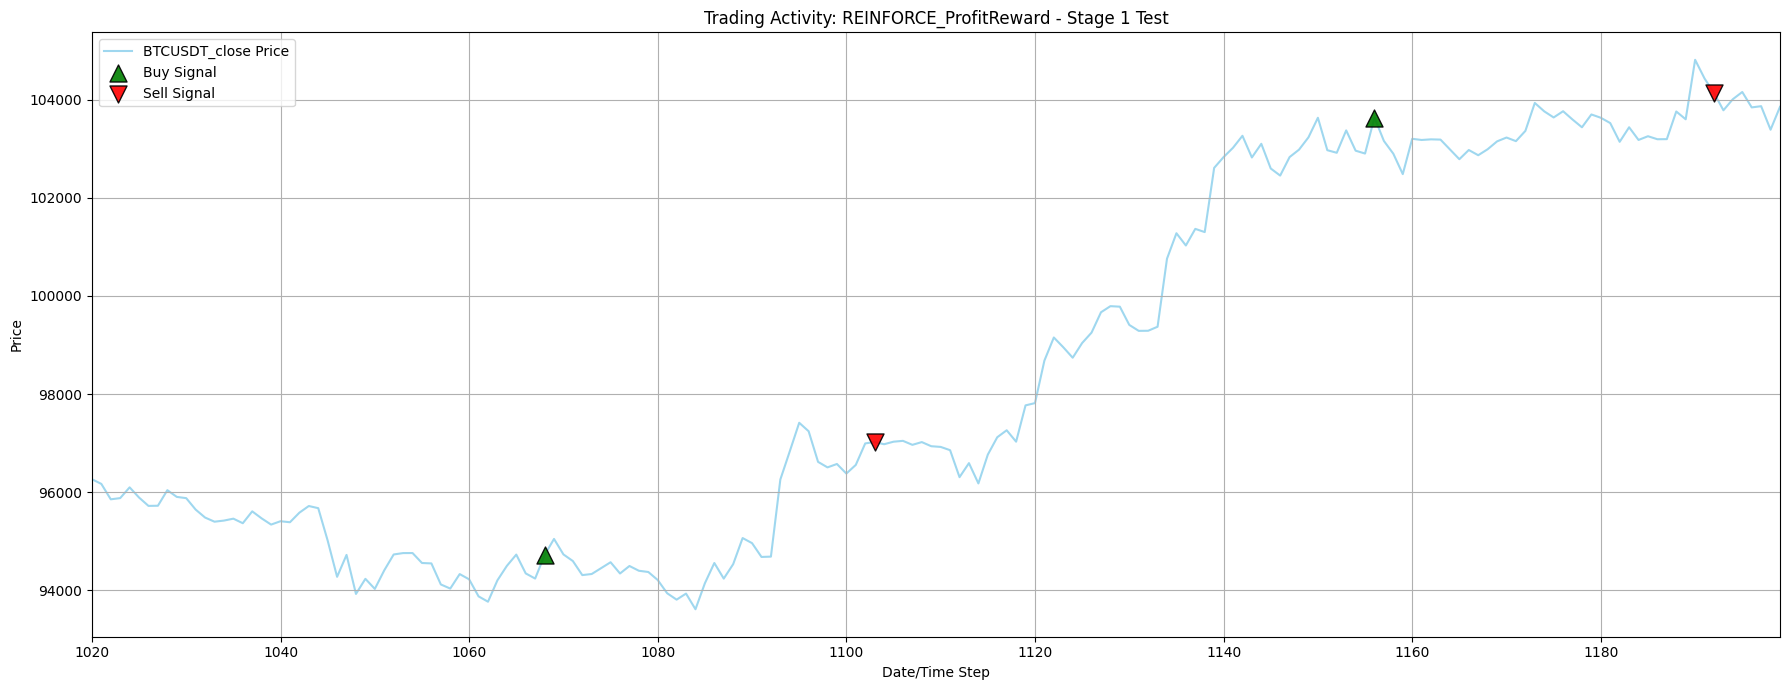


--- Evaluating Test Performance: REINFORCE_LogReturnReward ---
REINFORCE_LogReturnReward - Test Metrics:
  Final Net Worth: 991523.2705
  Total Return (%): -0.8477
  Sharpe Ratio (step-wise reward): -0.1197
  Max Drawdown (%): -1.0095
  Number of Trades: 6.0000


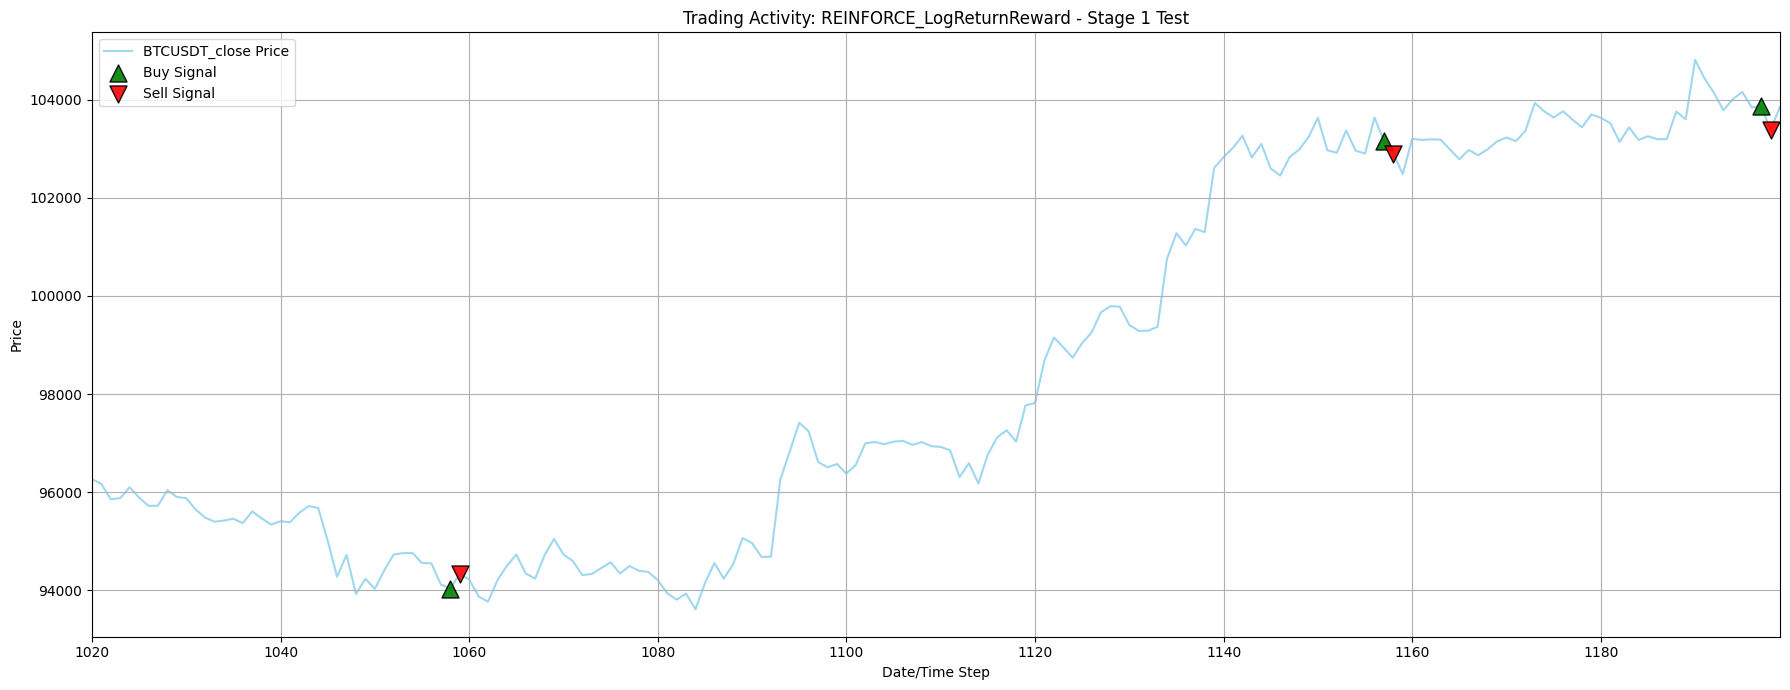


--- Evaluating Test Performance: A2C_ProfitReward ---
A2C_ProfitReward - Test Metrics:
  Final Net Worth: 1000000.0000
  Total Return (%): 0.0000
  Sharpe Ratio (step-wise reward): 0.0000
  Max Drawdown (%): 0.0000
  Number of Trades: 0.0000
No trades in trade_history to plot for A2C_ProfitReward.


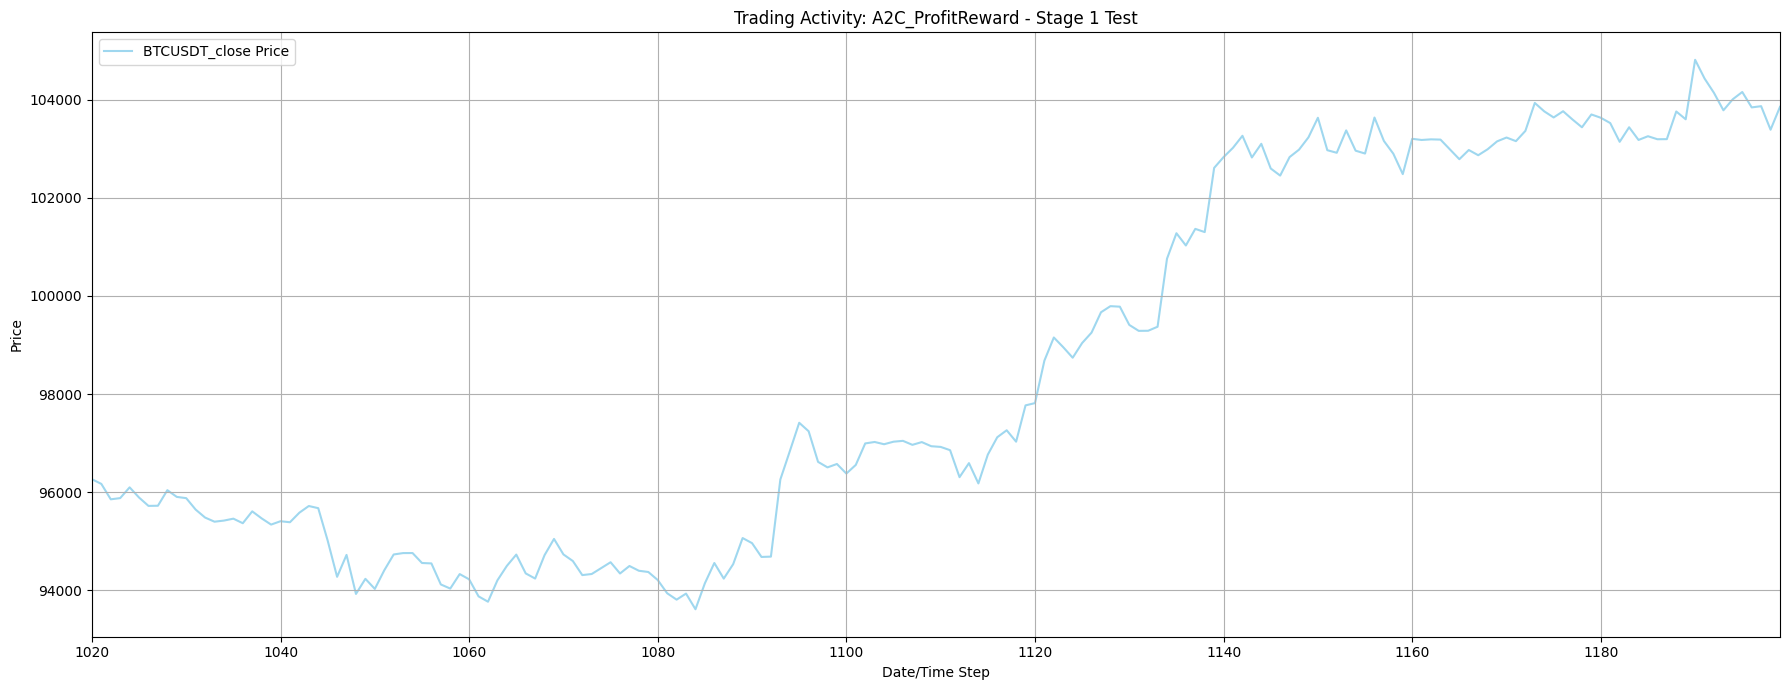


--- Evaluating Test Performance: A2C_LogReturnReward ---
A2C_LogReturnReward - Test Metrics:
  Final Net Worth: 1000000.0000
  Total Return (%): 0.0000
  Sharpe Ratio (step-wise reward): 0.0000
  Max Drawdown (%): 0.0000
  Number of Trades: 0.0000
No trades in trade_history to plot for A2C_LogReturnReward.


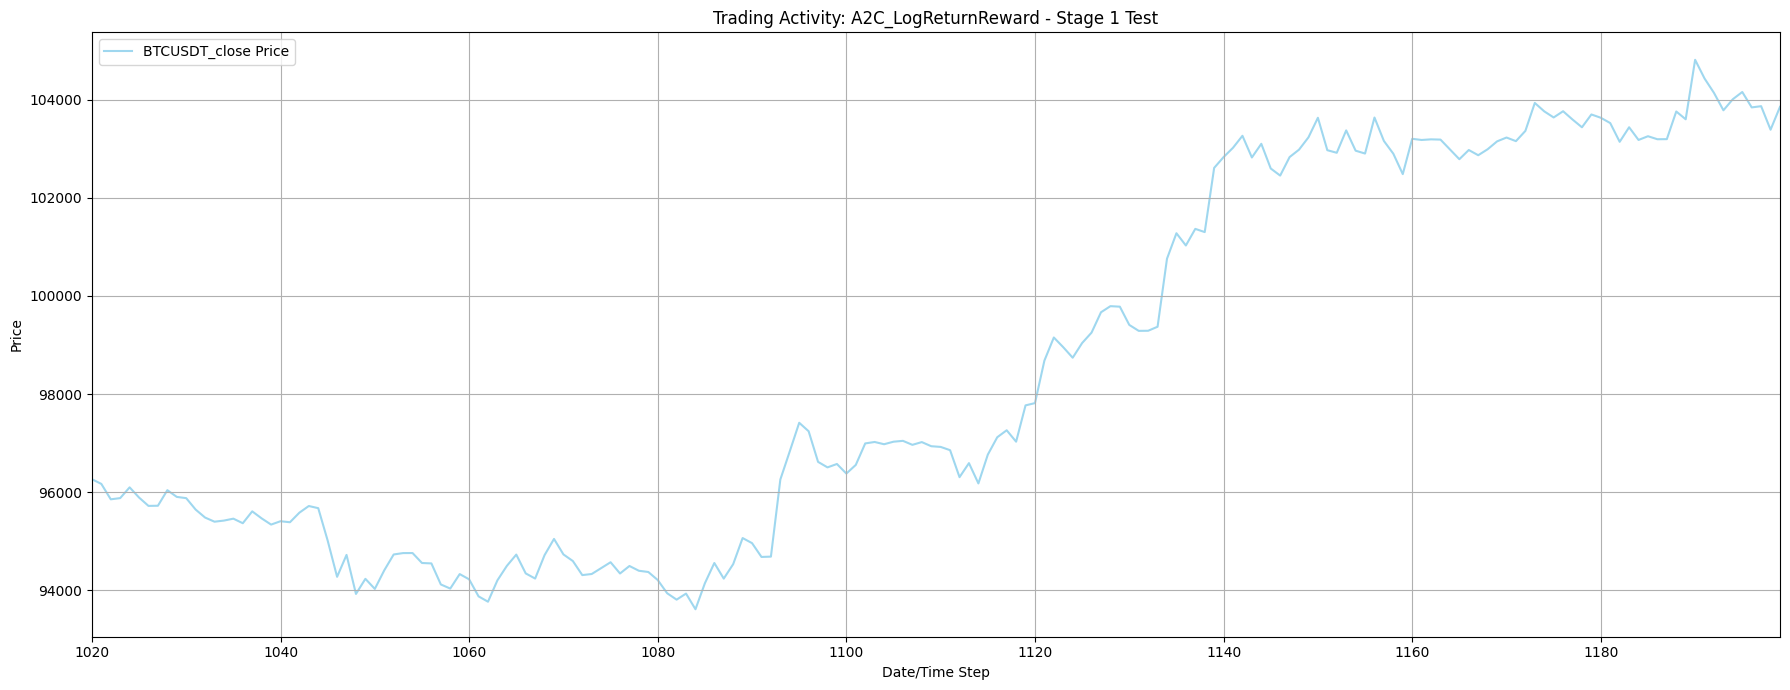

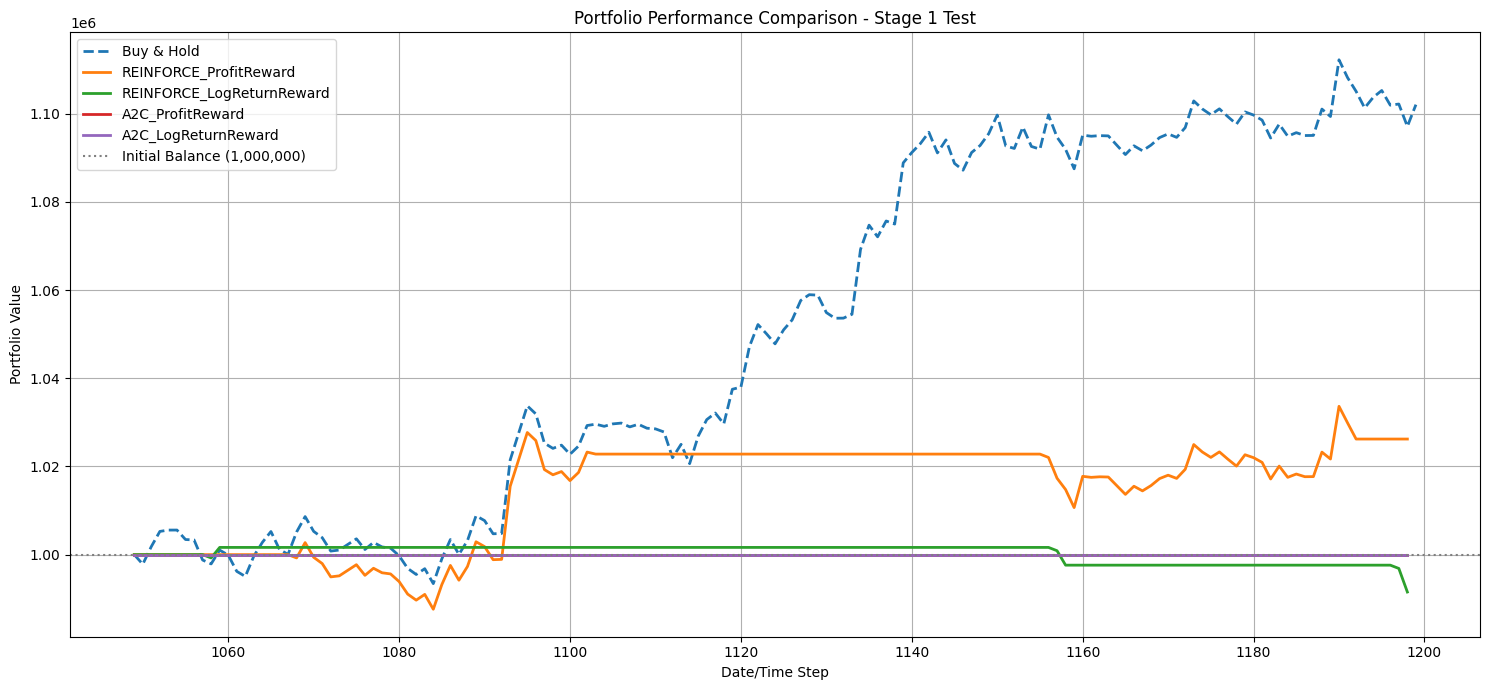



--- STAGE 1 TEST PERFORMANCE SUMMARY ---
                           Final Net Worth  Total Return (%)  Sharpe Ratio (step-wise reward)  Max Drawdown (%)  Number of Trades
Experiment                                                                                                                       
Buy & Hold                    1102028.7538           10.2029                           0.1737           -1.5072                 2
REINFORCE_ProfitReward        1026207.8487            2.6208                           0.0673           -1.6570                 4
REINFORCE_LogReturnReward      991523.2705           -0.8477                          -0.1197           -1.0095                 6
A2C_ProfitReward              1000000.0000            0.0000                           0.0000            0.0000                 0
A2C_LogReturnReward           1000000.0000            0.0000                           0.0000            0.0000                 0


--- Plotting Trades for Last Training Episode

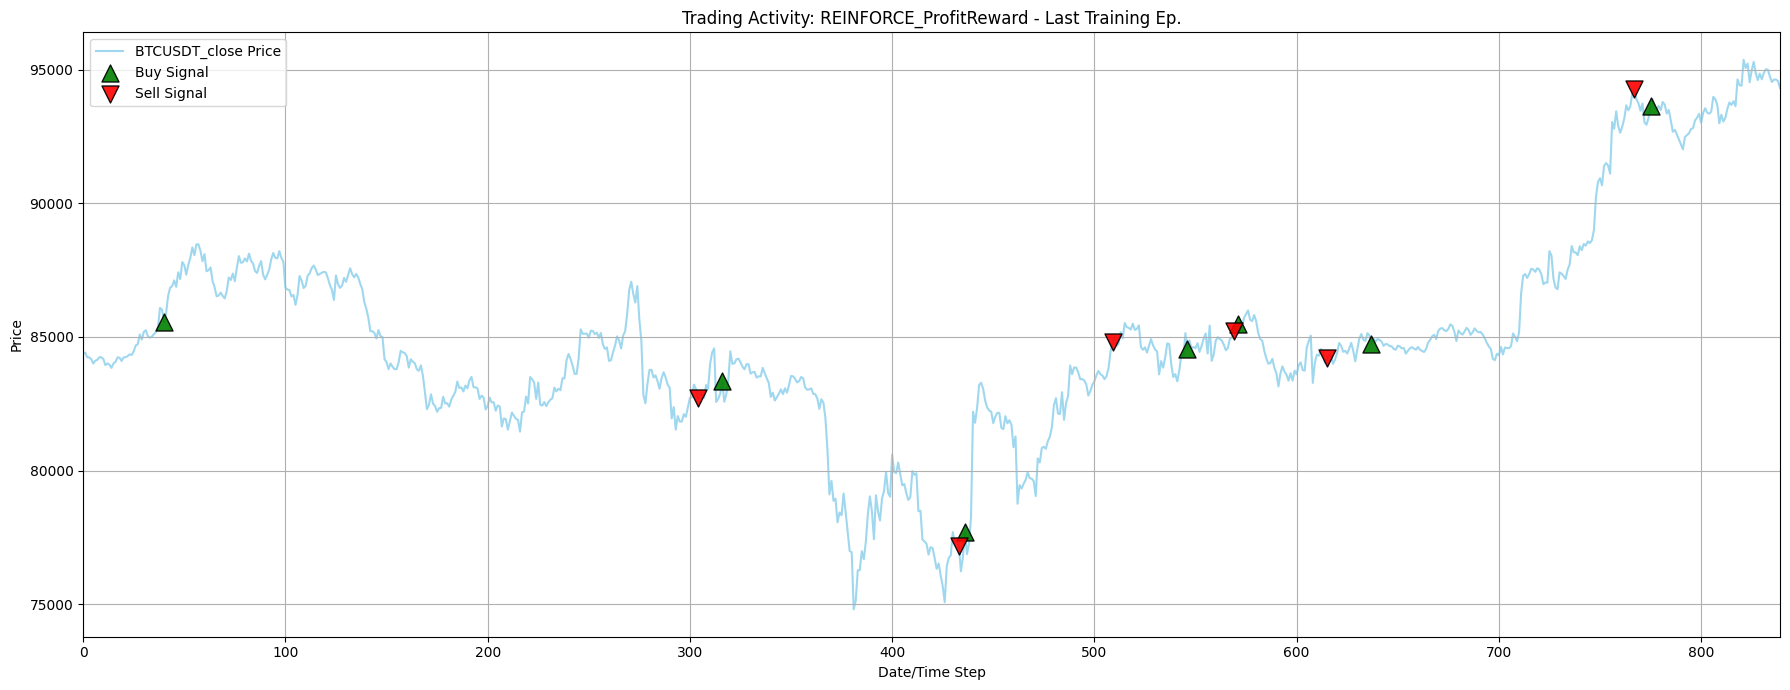

Plotting last training episode trades for: REINFORCE_LogReturnReward


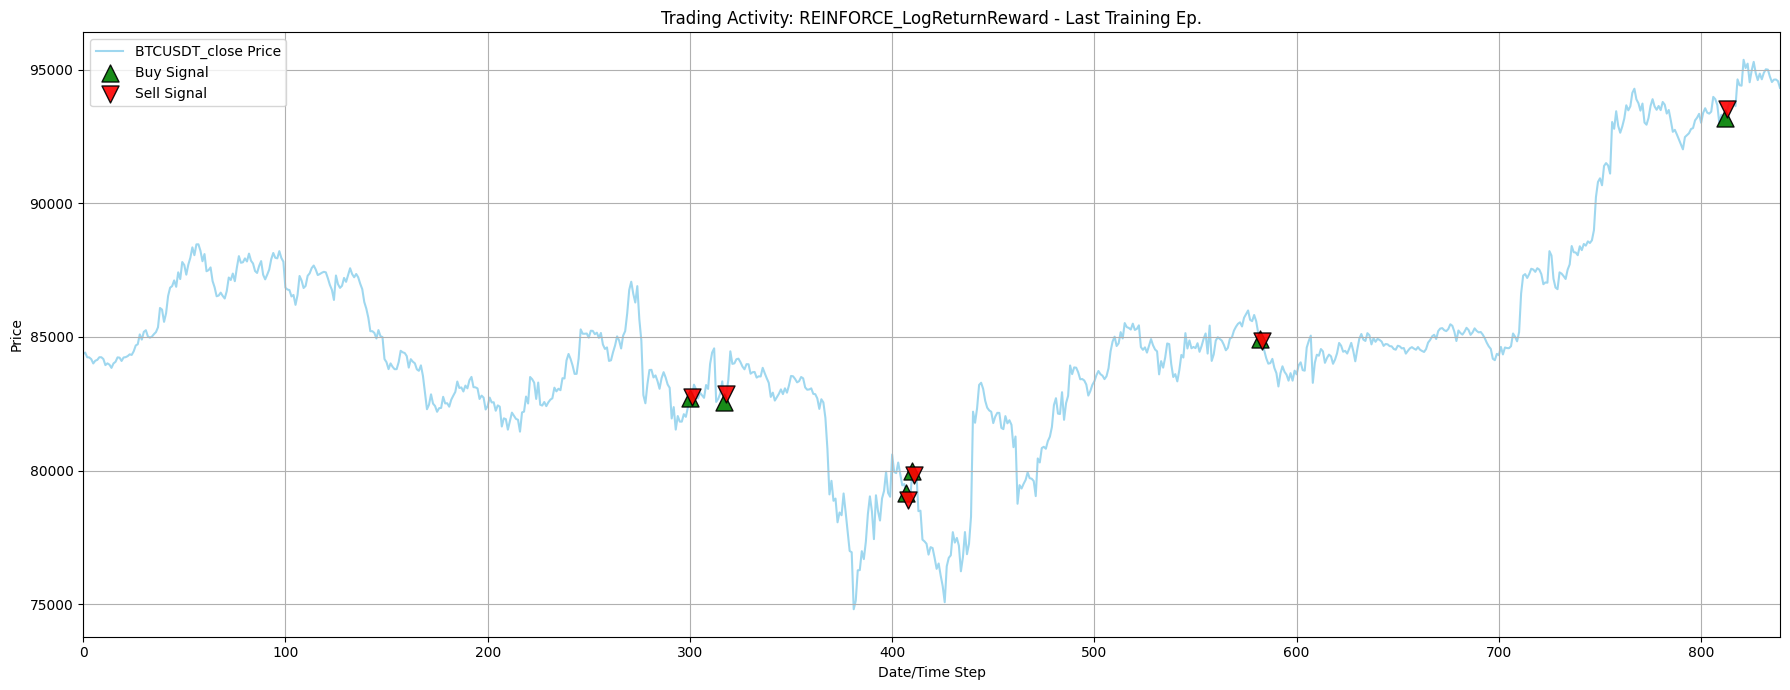

No trades recorded in the last training episode for A2C_ProfitReward.
No trades recorded in the last training episode for A2C_LogReturnReward.


In [9]:

TEST_INITIAL_BALANCE = 1000000.0 
# trained_agents_stage1, stage1_configs, last_train_episode_trades_stage1 (from Stage 1 Training)

# --- Make sure necessary imports are active ---
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print(f"{'='*20} STAGE 1 RESULTS EVALUATION {'='*20}")

stage1_test_results_for_plotting = {}
stage1_test_summary_metrics_list = []

# --- Calculate Buy and Hold for the test period (once) ---
bh_prices_for_period_s1 = test_data.iloc[WINDOW_SIZE-1:]
bh_net_worth_ts_s1 = pd.Series(dtype='float64')
bh_final_net_worth_s1 = TEST_INITIAL_BALANCE
bh_total_return_pct_s1 = 0.0; bh_sharpe_s1 = 0.0; bh_max_drawdown_s1 = 0.0
if not bh_prices_for_period_s1.empty:
    bh_net_worth_ts_s1 = (bh_prices_for_period_s1 / bh_prices_for_period_s1.iloc[0]) * TEST_INITIAL_BALANCE
    if not bh_net_worth_ts_s1.empty: bh_final_net_worth_s1 = bh_net_worth_ts_s1.iloc[-1]
    bh_total_return_pct_s1 = (bh_final_net_worth_s1 - TEST_INITIAL_BALANCE) / (TEST_INITIAL_BALANCE + 1e-9) * 100
    bh_asset_returns_s1 = bh_prices_for_period_s1.pct_change().dropna()
    bh_sharpe_s1 = np.mean(bh_asset_returns_s1) / (np.std(bh_asset_returns_s1) + 1e-9) if len(bh_asset_returns_s1) > 1 and np.std(bh_asset_returns_s1) > 1e-9 else 0
    if not bh_asset_returns_s1.empty:
        bh_cumulative_asset_returns_s1 = (1 + bh_asset_returns_s1).cumprod()
        bh_peak_asset_s1 = bh_cumulative_asset_returns_s1.expanding(min_periods=1).max()
        bh_drawdown_asset_s1 = (bh_cumulative_asset_returns_s1 - bh_peak_asset_s1) / (bh_peak_asset_s1 + 1e-9)
        bh_max_drawdown_s1 = bh_drawdown_asset_s1.min() * 100

stage1_test_results_for_plotting["Buy & Hold"] = {'net_worth_series': bh_net_worth_ts_s1, 'trades': [], 'linestyle': '--'}
bh_metrics_dict_s1 = {
    "Final Net Worth": bh_final_net_worth_s1, "Total Return (%)": bh_total_return_pct_s1,
    "Sharpe Ratio (step-wise reward)": bh_sharpe_s1,
    "Max Drawdown (%)": bh_max_drawdown_s1, "Number of Trades": 2
}
stage1_test_summary_metrics_list.append({"Experiment": "Buy & Hold", **bh_metrics_dict_s1})

# --- Evaluate each trained agent from Stage 1 ---
if 'trained_agents_stage1' in globals() and trained_agents_stage1: # Check if dict exists and is not empty
    for exp_name, agent in trained_agents_stage1.items():
        print(f"\n--- Evaluating Test Performance: {exp_name} ---")
        
        config_for_agent = stage1_configs.get(exp_name)
        if not config_for_agent:
            print(f"Warning: Config for {exp_name} not found. Using default reward_type for test_env.")
            reward_type_for_test_env = "log_return" # Fallback
        else:
            reward_type_for_test_env = config_for_agent["reward_type"]

        test_env_eval = TradingEnv( # Use your working TradingEnv class
            test_data,
            window_size=WINDOW_SIZE,
            reward_type=reward_type_for_test_env,
            transaction_cost_pct=TRANSACTION_COST,
            initial_balance=TEST_INITIAL_BALANCE,
            constraint_type=None, # No constraints in Stage 1
            DEBUG_MODE=False
        )

        # ======== CALL run_evaluation_and_collect_history HERE ========
        metrics, net_worth_ts, trades = run_evaluation_and_collect_history(
            test_env_eval, agent, test_data
        )
        # =============================================================

        print(f"{exp_name} - Test Metrics:")
        for metric_key, metric_value in metrics.items(): print(f"  {metric_key}: {metric_value:.4f}")

        stage1_test_results_for_plotting[exp_name] = {'net_worth_series': net_worth_ts, 'trades': trades, 'linestyle': '-'}
        stage1_test_summary_metrics_list.append({"Experiment": exp_name, **metrics})

        plot_trades_on_price(exp_name, trades, test_data, title_suffix=" - Stage 1 Test")
        plt.show()
else:
    print("Warning: 'trained_agents_stage1' dictionary not found or empty. Skipping Stage 1 test evaluations.")

# --- Plot combined portfolio performance for Stage 1 Test Results ---
if stage1_test_results_for_plotting: # Check if there's anything to plot
    plot_portfolio_performance(stage1_test_results_for_plotting, TEST_INITIAL_BALANCE, title_suffix=" - Stage 1 Test")
    plt.show()

# --- Print Stage 1 Test Summary Table ---
summary_df_s1 = pd.DataFrame(stage1_test_summary_metrics_list)
if not summary_df_s1.empty:
    print("\n\n--- STAGE 1 TEST PERFORMANCE SUMMARY ---")
    pd.options.display.float_format = '{:.4f}'.format
    print(summary_df_s1.set_index("Experiment").to_string())

# --- Plot Trades for Last Training Episode of Stage 1 Models ---
print("\n\n--- Plotting Trades for Last Training Episode (Stage 1) ---")
if 'last_train_episode_trades_stage1' in globals() and last_train_episode_trades_stage1:
    for config_name, trades in last_train_episode_trades_stage1.items():
        if trades:
            print(f"Plotting last training episode trades for: {config_name}")
            plot_trades_on_price(f"{config_name}", trades, train_data, title_suffix=" - Last Training Ep.")

        #     plot_trades_on_price(
        #     exp_name,
        #     trades, # The trades collected from the run on test_data
        #     test_data,           # The price_series_for_plot is test_data
        #     title_suffix=" - Stage 1 Test"
        # )
            plt.show()
        else:
            print(f"No trades recorded in the last training episode for {config_name}.")
else:
    print("Variable 'last_train_episode_trades_stage1' not found/empty. Skipping plots.")

Training two more nuanced
# 5.2. Stage 2: Applying Constraints to REINFORCE Models
# Based on Stage 1, we select promising REINFORCE configurations and apply constraints.


--- Stage 2: Applying constraints based on 'REINFORCE_LogReturnReward' ---

--- Training: REINFORCE_LogReturnReward_Constraint_HighVolNoTrade_S2 ---


REINFORCE_LogReturnReward_Constraint_HighVolNoTrade_S2 - Ep 10/200, Train Rew: -0.0652, Loss: -2.8814, Val NW: 999707.93
REINFORCE_LogReturnReward_Constraint_HighVolNoTrade_S2 - Ep 20/200, Train Rew: -0.0886, Loss: -3.7450, Val NW: 988746.67
REINFORCE_LogReturnReward_Constraint_HighVolNoTrade_S2 - Ep 30/200, Train Rew: -0.0188, Loss: -0.5952, Val NW: 995312.80
REINFORCE_LogReturnReward_Constraint_HighVolNoTrade_S2 - Ep 40/200, Train Rew: -0.0442, Loss: -1.3669, Val NW: 997624.17
REINFORCE_LogReturnReward_Constraint_HighVolNoTrade_S2 - Ep 50/200, Train Rew: -0.0440, Loss: -1.0005, Val NW: 1000000.00
REINFORCE_LogReturnReward_Constraint_HighVolNoTrade_S2 - Ep 60/200, Train Rew: -0.0106, Loss: -0.1580, Val NW: 999683.43
REINFORCE_LogReturnReward_Constraint_HighVolNoTrade_S2 - Ep 70/200, Train Rew: -0.0185, Loss: -0.1781, Val NW: 999646.53
REINFORCE_LogReturnReward_Constraint_HighVolNoTrade_S2 - Ep 80/200, Train Rew: -0.0184, Loss: -0.1164, Val NW: 1000000.00
REINFORCE_LogReturnReward_Cons

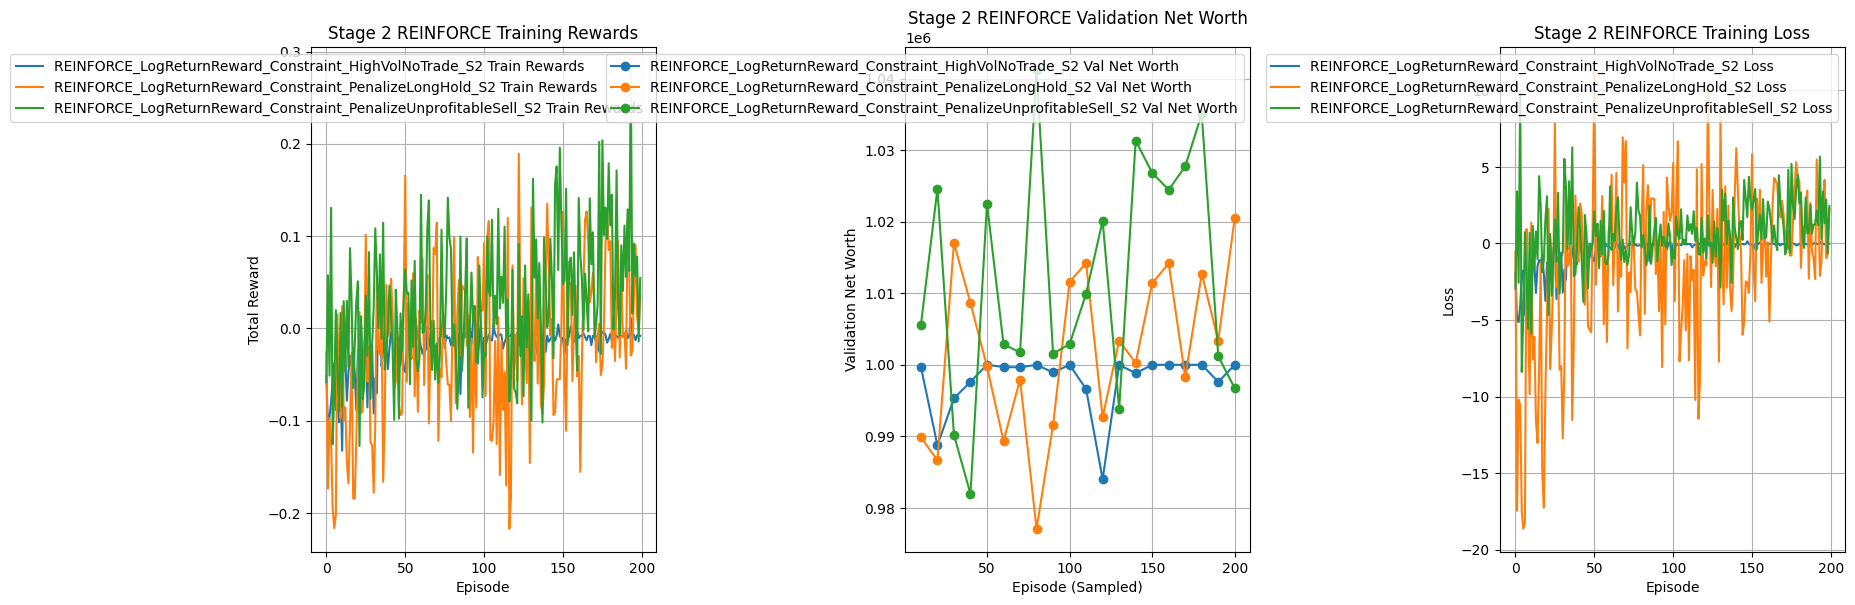


--- Stage 2 Evaluation (Test Set) ---

Evaluating REINFORCE_LogReturnReward_Constraint_HighVolNoTrade_S2 on Test Set...
REINFORCE_LogReturnReward_Constraint_HighVolNoTrade_S2 - Test Avg Reward: -0.0015, Final Net Worth: 1000000.00

Evaluating REINFORCE_LogReturnReward_Constraint_PenalizeLongHold_S2 on Test Set...
REINFORCE_LogReturnReward_Constraint_PenalizeLongHold_S2 - Test Avg Reward: 0.0763, Final Net Worth: 1079781.18

Evaluating REINFORCE_LogReturnReward_Constraint_PenalizeUnprofitableSell_S2 on Test Set...
REINFORCE_LogReturnReward_Constraint_PenalizeUnprofitableSell_S2 - Test Avg Reward: 0.0031, Final Net Worth: 1008070.32

Stage 2 Test Summary:
                                                                  Test Final Net Worth  Test Avg Reward
Experiment                                                                                             
REINFORCE_LogReturnReward_Constraint_HighVolNoTrade_S2                    1000000.0000          -0.0015
REINFORCE_LogReturnReward

In [ ]:


reinforce_base_config_name_s2 = "REINFORCE_LogReturnReward"

if reinforce_base_config_name_s2 not in trained_agents_stage1:
    print(f"Error: Baseline REINFORCE config '{reinforce_base_config_name_s2}' not found in Stage 1 results. Ensure Stage 1 ran correctly. Skipping Stage 2.")
else:
    print(f"--- Stage 2: Applying constraints based on '{reinforce_base_config_name_s2}' ---")

    # Define constraint(s) to test for this chosen REINFORCE base
    constraints_to_test_s2 = {
        # It's good to have a "NoConstraint" version trained with the same episode count
        # as the constrained versions for a fair comparison, even if similar to Stage 1.
        # "NoConstraint_S2Baseline": {
        #     "constraint_type": None,
        #     # No other constraint-specific params needed
        # },
        "HighVolNoTrade_S2": {
            "constraint_type": "no_trade_high_volatility",
            "volatility_lookback": 20,  # Example, tune this
            "volatility_threshold_pct": 0.015 # Example, tune this (e.g., 1.5% std dev of log returns)
        },
        "PenalizeLongHold_S2": {
            "constraint_type": "penalize_long_hold",
            "max_hold_duration": 30 # e.g., penalize if holding for more than 30 steps
        },
        "PenalizeUnprofitableSell_S2": {
            "constraint_type": "penalize_unprofitable_sell",
            "min_profit_pct_for_sell": 0.0075 # e.g., penalize if sell profit < 0.75% (after costs)
        },

    }

    # Get original agent params and settings for the chosen REINFORCE baseline
    base_agent_params_s2 = stage1_configs[reinforce_base_config_name_s2]["agent_params"]
    base_reward_type_s2 = stage1_configs[reinforce_base_config_name_s2]["reward_type"]
    # You can use the same number of episodes or adjust for Stage 2
    n_episodes_s2 = stage1_configs[reinforce_base_config_name_s2]["n_episodes"]
    # n_episodes_s2 = 100 # Or a different number for quicker Stage 2 runs


    trained_agents_stage2 = {}
    training_histories_stage2 = {}
    last_train_episode_trades_stage2 = {} 


    for constraint_key, constraint_config_params in constraints_to_test_s2.items():
        # Construct a descriptive name for this specific Stage 2 experiment
        current_config_name_s2 = f"{reinforce_base_config_name_s2}_Constraint_{constraint_key}"
        print(f"\n--- Training: {current_config_name_s2} ---")

        # Instantiate Environment with the current constraint configuration
        train_env_s2 = TradingEnv(
            train_data,
            window_size=WINDOW_SIZE,
            reward_type=base_reward_type_s2,
            transaction_cost_pct=TRANSACTION_COST,
            constraint_type=constraint_config_params["constraint_type"],
            volatility_lookback=constraint_config_params.get("volatility_lookback", 20), # Use .get for safety
            volatility_threshold_pct=constraint_config_params.get("volatility_threshold_pct", 0.02),
            DEBUG_MODE=False 
        )
        val_env_s2 = TradingEnv(
            val_data,
            window_size=WINDOW_SIZE,
            reward_type=base_reward_type_s2,
            transaction_cost_pct=TRANSACTION_COST,
            constraint_type=constraint_config_params["constraint_type"],
            volatility_lookback=constraint_config_params.get("volatility_lookback", 20),
            volatility_threshold_pct=constraint_config_params.get("volatility_threshold_pct", 0.02),
            DEBUG_MODE=False
        )

        # Instantiate a new REINFORCE Agent for this constrained training
        # (using same base agent params for consistency in comparing constraint effect)
        agent_s2 = REINFORCEAgent(
            state_dim=(WINDOW_SIZE,),
            action_dim=train_env_s2.action_space.n,
            learning_rate=base_agent_params_s2["learning_rate"],
            gamma=base_agent_params_s2["gamma"]
        )

        episode_rewards_history = []
        val_net_worths_history = []
        losses_history = []

        for episode in range(n_episodes_s2):
            obs, info = train_env_s2.reset()
            done = False
            episode_reward_sum = 0
            agent_s2.trajectory_states, agent_s2.trajectory_actions, agent_s2.trajectory_rewards = [], [], []

            while not done:
                action = agent_s2.select_action(obs)
                next_obs, reward, terminated, truncated, info = train_env_s2.step(action)
                done = terminated or truncated
                agent_s2.store_transition(obs, action, reward)
                episode_reward_sum += reward
                obs = next_obs
            loss = agent_s2.update()
            episode_rewards_history.append(episode_reward_sum)
            losses_history.append(loss)

            if (episode + 1) % 10 == 0: # Validation frequency
                _, val_net_worth = evaluate_agent(val_env_s2, agent_s2, num_episodes=1)
                val_net_worths_history.append(val_net_worth)
                print(f"{current_config_name_s2} - Ep {episode+1}/{n_episodes_s2}, Train Rew: {episode_reward_sum:.4f}, Loss: {loss:.4f}, Val NW: {val_net_worth:.2f}")

            if episode == n_episodes_s2 - 1: # If it's the last training episode
                last_train_episode_trades_stage2[current_config_name_s2] = train_env_s2.trade_history.copy()
        
        trained_agents_stage2[current_config_name_s2] = agent_s2
        training_histories_stage2[current_config_name_s2] = {
            "rewards": episode_rewards_history,
            "val_net_worths": val_net_worths_history,
            "losses": losses_history
        }
        print(f"--- Training complete for {current_config_name_s2} ---")

    # --- Plotting Training Progress for Stage 2 (Comparing constrained models) ---
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    for config_name, history in training_histories_stage2.items():
        plt.plot(history["rewards"], label=f'{config_name} Train Rewards')
    plt.xlabel('Episode'); plt.ylabel('Total Reward'); plt.title('Stage 2 REINFORCE Training Rewards'); plt.legend(); plt.grid(True)

    plt.subplot(1, 3, 2)
    for config_name, history in training_histories_stage2.items():
        val_episodes_x = [(i + 1) * 10 for i in range(len(history["val_net_worths"]))]
        plt.plot(val_episodes_x, history["val_net_worths"], label=f'{config_name} Val Net Worth', marker='o')
    plt.xlabel('Episode (Sampled)'); plt.ylabel('Validation Net Worth'); plt.title('Stage 2 REINFORCE Validation Net Worth'); plt.legend(); plt.grid(True)

    plt.subplot(1, 3, 3)
    for config_name, history in training_histories_stage2.items():
        plt.plot(history["losses"], label=f'{config_name} Loss')
    plt.xlabel('Episode'); plt.ylabel('Loss'); plt.title('Stage 2 REINFORCE Training Loss'); plt.legend(); plt.grid(True)

    plt.tight_layout()
    plt.show()

    # --- Stage 2 Evaluation (on Test Set) ---
    print("\n--- Stage 2 Evaluation (Test Set) ---")
    stage2_summary_metrics = []

    # You'll need your run_evaluation_and_collect_history function here
    # from previous discussions if you want detailed plots for each.
    # For now, simplified printout:
    for config_name_s2_eval, agent_s2_eval in trained_agents_stage2.items():
        print(f"\nEvaluating {config_name_s2_eval} on Test Set...")
        
        # Extract constraint key to correctly setup test_env
        # This assumes constraint_key is the last part after "_Constraint_"
        parts = config_name_s2_eval.split("_Constraint_")
        constraint_key_for_test = parts[-1] if len(parts) > 1 else "NoConstraint_S2Baseline" # Fallback
        
        if constraint_key_for_test not in constraints_to_test_s2:
            print(f"Warning: Could not find constraint config for '{constraint_key_for_test}' from experiment name '{config_name_s2_eval}'. Assuming no constraint for test.")
            current_constraint_params_for_test = {"constraint_type": None}
        else:
            current_constraint_params_for_test = constraints_to_test_s2[constraint_key_for_test]

        test_env_s2_eval = TradingEnv(
            test_data,
            window_size=WINDOW_SIZE,
            reward_type=base_reward_type_s2, # Use the base reward type consistent with training
            transaction_cost_pct=TRANSACTION_COST,
            constraint_type=current_constraint_params_for_test["constraint_type"],
            volatility_lookback=current_constraint_params_for_test.get("volatility_lookback", 20),
            volatility_threshold_pct=current_constraint_params_for_test.get("volatility_threshold_pct", 0.02),
            DEBUG_MODE=False
        )
        
        avg_reward, final_net_worth = evaluate_agent(test_env_s2_eval, agent_s2_eval, num_episodes=1)
        # metrics, net_worth_ts, trades = run_evaluation_and_collect_history(test_env_s2_eval, agent_s2_eval, test_data)
        # stage2_summary_metrics.append({"Experiment": config_name_s2_eval, **metrics})
        # plot_portfolio_performance({config_name_s2_eval: {'net_worth_series': net_worth_ts}}, initial_balance, title_suffix=f" - {config_name_s2_eval}")
        # plot_trades_on_price(config_name_s2_eval, trades, test_data, title_suffix=f" - {config_name_s2_eval}")
        
        print(f"{config_name_s2_eval} - Test Avg Reward: {avg_reward:.4f}, Final Net Worth: {final_net_worth:.2f}")
        stage2_summary_metrics.append({
            "Experiment": config_name_s2_eval,
            "Test Final Net Worth": final_net_worth,
            "Test Avg Reward": avg_reward
            # Add more metrics from your full evaluation here
        })

    summary_df_stage2 = pd.DataFrame(stage2_summary_metrics)
    if not summary_df_stage2.empty:
        print("\nStage 2 Test Summary:")
        print(summary_df_stage2.set_index("Experiment").to_string()) # .to_string() for better printing if many columns

 

## Stage 2 Results Interpretation: Impact of Constraints on REINFORCE (Log Return Reward)

Stage 2 focused on applying different constraints to the REINFORCE agent that was previously trained using 'log_return' rewards. The goal was to see if these constraints could improve its performance, stability, or trading behavior compared to an unconstrained version (which in Stage 1, struggled to achieve consistent profitability on validation, often hovering around break-even). All models in Stage 2 used the 'log_return' base reward. Initial capital for testing was $1,000,000.

### Visual Analysis of Stage 2 Training Curves:

*   **Stage 2 REINFORCE Training Rewards (Left Plot):**
    *   **HighVolNoTrade_S2 (Blue):** This agent's training rewards are consistently very close to zero, often slightly negative. This suggests that the "no trade during high volatility" constraint might be preventing many trades, or the trades it does make are not significantly profitable on average during training. The rewards are much smaller in magnitude compared to the other two constrained models.
    *   **PenalizeLongHold_S2 (Orange):** Shows more variance in training rewards than the `HighVolNoTrade` agent. Rewards fluctuate between approximately -0.2 and +0.2. This indicates more active trading, with both winning and losing episodes. The penalty for holding too long seems to encourage more frequent exits or entries.
    *   **PenalizeUnprofitableSell_S2 (Green):** This agent exhibits the highest variance and magnitude in training rewards among the three, often reaching above +0.2 and dipping below -0.1. This suggests it's actively trading and experiencing more pronounced winning and losing episodes. The penalty for unprofitable sells might be forcing it to hold positions longer to achieve profitability, or to be more selective, leading to these larger reward swings.

*   **Stage 2 REINFORCE Validation Net Worth (Center Plot):**
    *   **HighVolNoTrade_S2 (Blue Circles):** The validation net worth for this agent remains very close to the initial $1M throughout training. It shows very little deviation, indicating that the constraint is likely leading to very conservative or infrequent trading on the validation set, resulting in neither significant gains nor losses. It essentially flatlines.
    *   **PenalizeLongHold_S2 (Orange Circles):** This agent shows more volatility in validation net worth. It has periods of gains (e.g., up to $1.017M) and dips (e.g., down to $0.975M). It ends the training period with validation net worth slightly above $1M (around $1.02M based on the last point). This suggests the constraint is influencing trading behavior, leading to some profitable periods but also some drawdowns.
    *   **PenalizeUnprofitableSell_S2 (Green Circles):** This agent demonstrates the most promising validation performance. It achieves the highest peaks (up to nearly $1.04M) and generally maintains a higher validation net worth throughout the latter half of training, ending around $1.02M. The constraint appears to help it capture more profitable trades or cut losses in a way that benefits validation performance, despite the higher variance in training rewards.

*   **Stage 2 REINFORCE Training Loss (Right Plot):**
    *   **HighVolNoTrade_S2 (Blue):** The loss is very stable and close to zero, consistent with its low-activity training rewards.
    *   **PenalizeLongHold_S2 (Orange):** Shows significantly more variance in loss, with larger negative and positive spikes, corresponding to its more active trading and varied reward signals.
    *   **PenalizeUnprofitableSell_S2 (Green):** Also exhibits high variance in loss, similar to or slightly greater than the `PenalizeLongHold` agent, reflecting its active and varied reward outcomes during training.

### Test Set Performance (from provided logs):

| Experiment                                                       | Test Final Net Worth | Test Avg Reward |
| :--------------------------------------------------------------- | :-------------------: | :-------------: |
| REINFORCE_LogReturnReward_Constraint_HighVolNoTrade_S2           |     $1,000,000.00    |     -0.0015     |
| REINFORCE_LogReturnReward_Constraint_PenalizeLongHold_S2         |     $1,079,781.18    |      0.0763     |
| REINFORCE_LogReturnReward_Constraint_PenalizeUnprofitableSell_S2 |     $1,008,070.32    |      0.0031     |

*(Implicit Baseline: The unconstrained `REINFORCE_LogReturnReward` from Stage 1 ended validation near $1.00M, and its test performance would likely be similar or slightly worse due to no guiding constraints).*

### Interpretation of Constraint Impact:

1.  **`HighVolNoTrade_S2` Constraint:**
    *   **Effect:** This constraint seems to have made the agent extremely conservative. Both training rewards and validation net worth flatlined near the starting point. The test result confirms this, with a final net worth identical to the initial balance and a slightly negative average reward (likely due to very few trades just incurring costs, or the inaction penalty if it was active in the test environment setup).
    *   **Conclusion:** While potentially reducing risk by avoiding volatile periods, this specific implementation (thresholds, lookback period) led to learned inaction or insufficient trading to generate profit. The parameters (`volatility_threshold_pct`, `volatility_lookback`) would need careful tuning.

2.  **`PenalizeLongHold_S2` Constraint:**
    *   **Effect:** This constraint encouraged more active trading compared to the `HighVolNoTrade` agent, as seen in the more dynamic training rewards, losses, and validation net worth. The penalty for holding positions beyond `max_hold_duration` (30 steps in the example) likely forced the agent to close positions, leading to more realized gains/losses.
    *   **Test Performance:** This agent achieved the **highest final net worth ($1,079,781.18) and the highest average reward (0.0763) on the test set.**
    *   **Conclusion:** Penalizing prolonged holding appears to be a beneficial constraint for this REINFORCE agent with log returns. It might prevent the agent from getting stuck in stagnant positions and forces it to re-evaluate or realize profits/losses more frequently, leading to better overall performance in this instance.

3.  **`PenalizeUnprofitableSell_S2` Constraint:**
    *   **Effect:** The training curves showed high activity and variance, and the validation net worth was generally strong, often achieving high peaks. This suggests the agent was trying to hold trades until they met the profit target (`min_profit_pct_for_sell` = 0.75% in the example) or was penalized for early/unprofitable exits.
    *   **Test Performance:** It resulted in a modest profit on the test set ($1,008,070.32) with a small positive average reward (0.0031). While profitable, it was significantly outperformed by the `PenalizeLongHold` agent.
    *   **Conclusion:** Penalizing unprofitable sells helped the agent achieve some profitability over the baseline (implied unconstrained model) but was not as effective as penalizing long holds. It might be that forcing a minimum profit target sometimes leads to missing optimal exit points if the market reverses before the target is hit, or the penalty itself isn't shaping behavior as effectively as the long-hold penalty.

### Overall Stage 2 Conclusions:

*   Applying constraints significantly altered the behavior and performance of the REINFORCE agent using log returns.
*   The **`PenalizeLongHold_S2` constraint was the most effective in this set of experiments**, leading to substantial improvement in test set net worth compared to the other constrained models and likely the unconstrained baseline from Stage 1.
*   The `HighVolNoTrade_S2` constraint, with the current parameters, was too restrictive and led to inaction.
*   The `PenalizeUnprofitableSell_S2` constraint showed some benefit but was less impactful than penalizing long holds.
*   These results highlight that thoughtful constraint design can be crucial in guiding RL agents towards more desirable trading behaviors and potentially better performance, but the specific parameters of these constraints require careful tuning.

This interpretation should be complemented by a more detailed quantitative analysis from your `evaluate_and_plot_experiments` function, including metrics like Sharpe Ratio, Max Drawdown, and Number of Trades for each constrained model to get a fuller picture of their risk-return profiles.

### 6.2. Evaluation and Visualization of Stage 2 Results
(REINFORCE with Constraints)




==================== STAGE 2 RESULTS EVALUATION ====================

--- Evaluating Test Performance: REINFORCE_LogReturnReward_Constraint_HighVolNoTrade_S2 ---


REINFORCE_LogReturnReward_Constraint_HighVolNoTrade_S2 - Test Metrics:
  Final Net Worth: 1000000.0000
  Total Return (%): 0.0000
  Sharpe Ratio (step-wise reward): 0.0000
  Max Drawdown (%): 0.0000
  Number of Trades: 0.0000
No trades in trade_history to plot for REINFORCE_LogReturnReward_Constraint_HighVolNoTrade_S2.


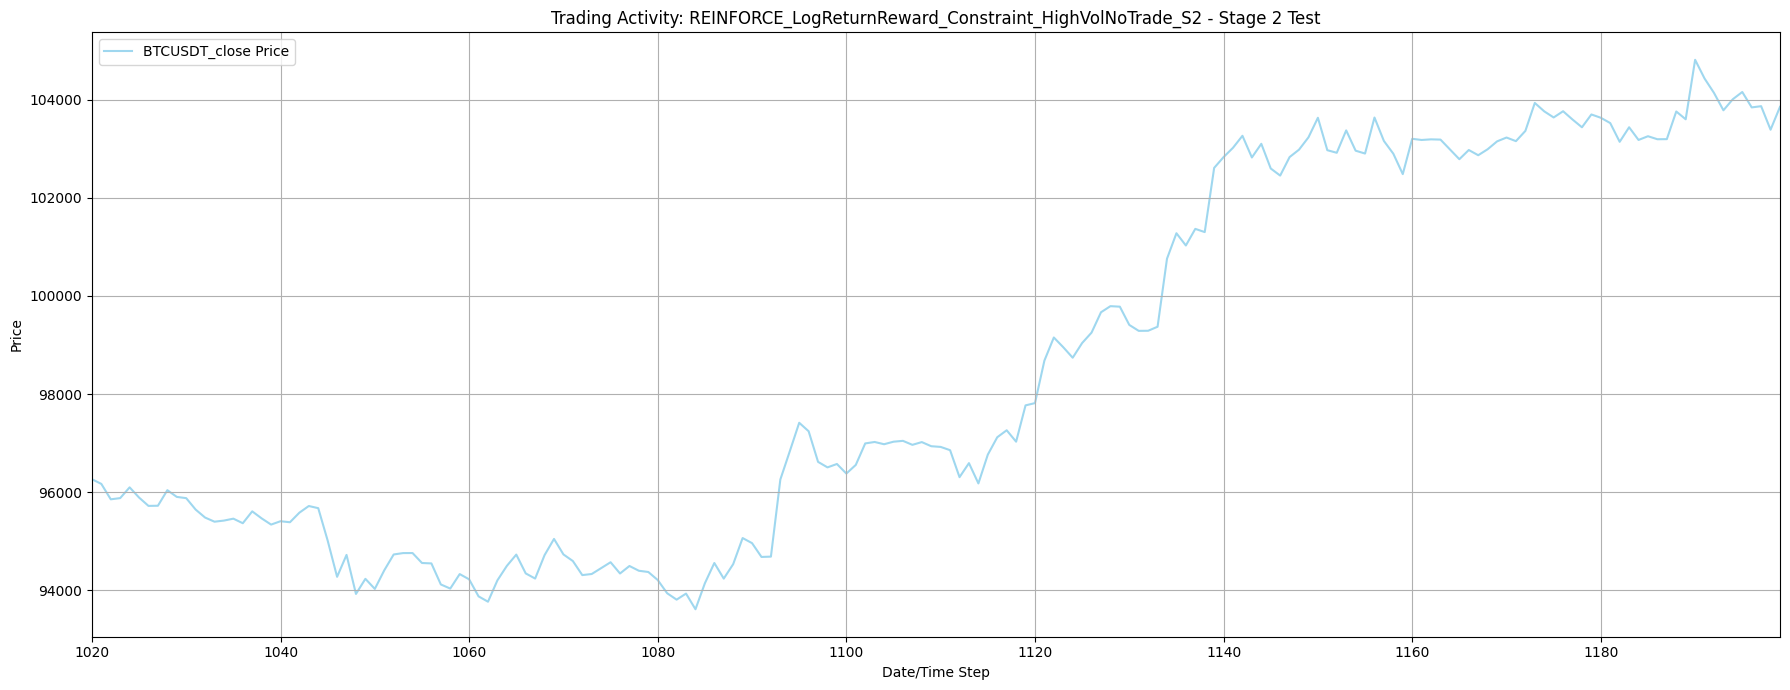


--- Evaluating Test Performance: REINFORCE_LogReturnReward_Constraint_PenalizeLongHold_S2 ---
REINFORCE_LogReturnReward_Constraint_PenalizeLongHold_S2 - Test Metrics:
  Final Net Worth: 1000425.9513
  Total Return (%): 0.0426
  Sharpe Ratio (step-wise reward): -0.0014
  Max Drawdown (%): -1.8293
  Number of Trades: 12.0000


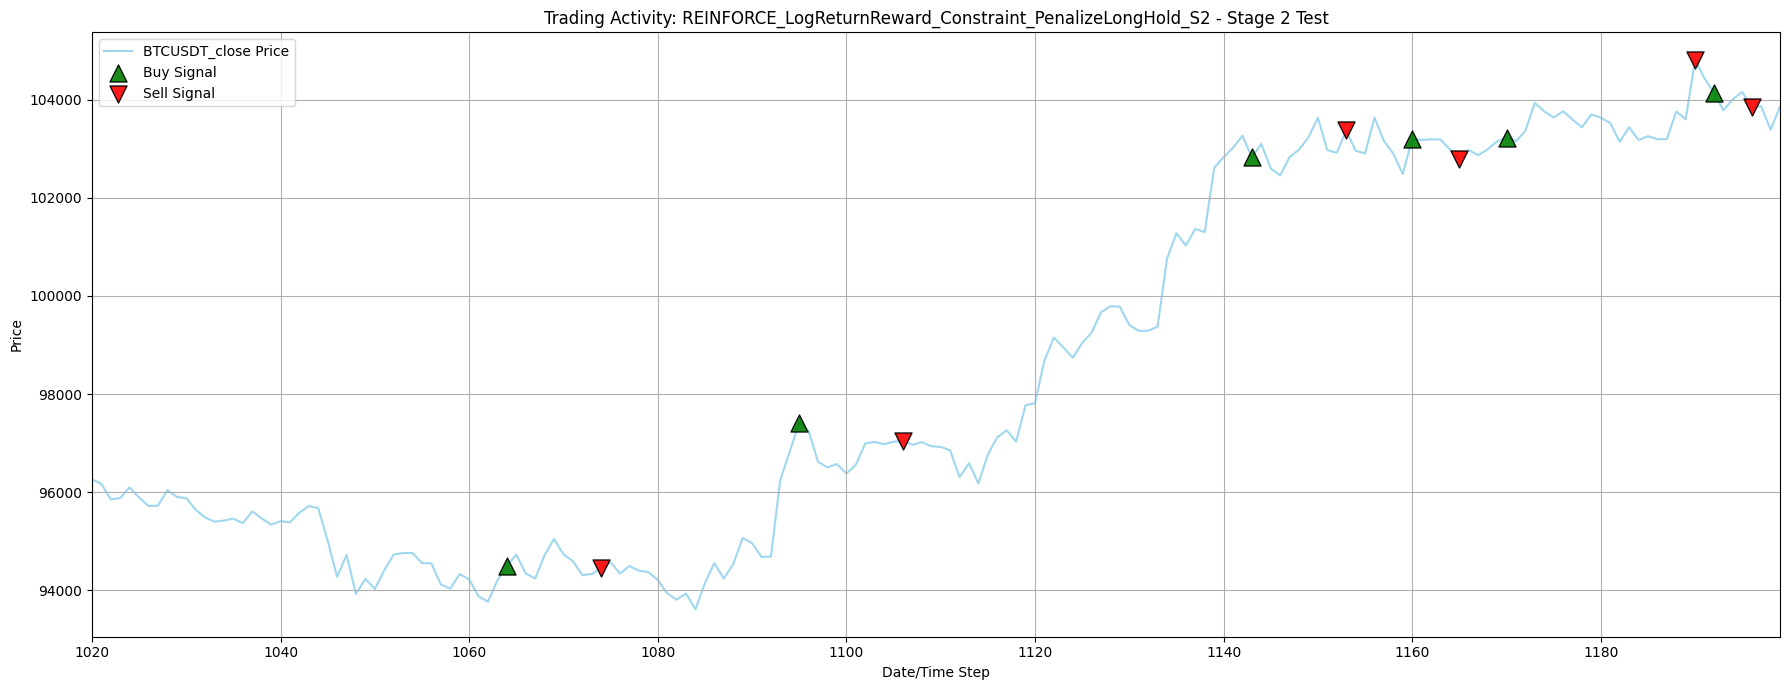


--- Evaluating Test Performance: REINFORCE_LogReturnReward_Constraint_PenalizeUnprofitableSell_S2 ---
REINFORCE_LogReturnReward_Constraint_PenalizeUnprofitableSell_S2 - Test Metrics:
  Final Net Worth: 1027225.3074
  Total Return (%): 2.7225
  Sharpe Ratio (step-wise reward): 0.0675
  Max Drawdown (%): -1.5072
  Number of Trades: 4.0000


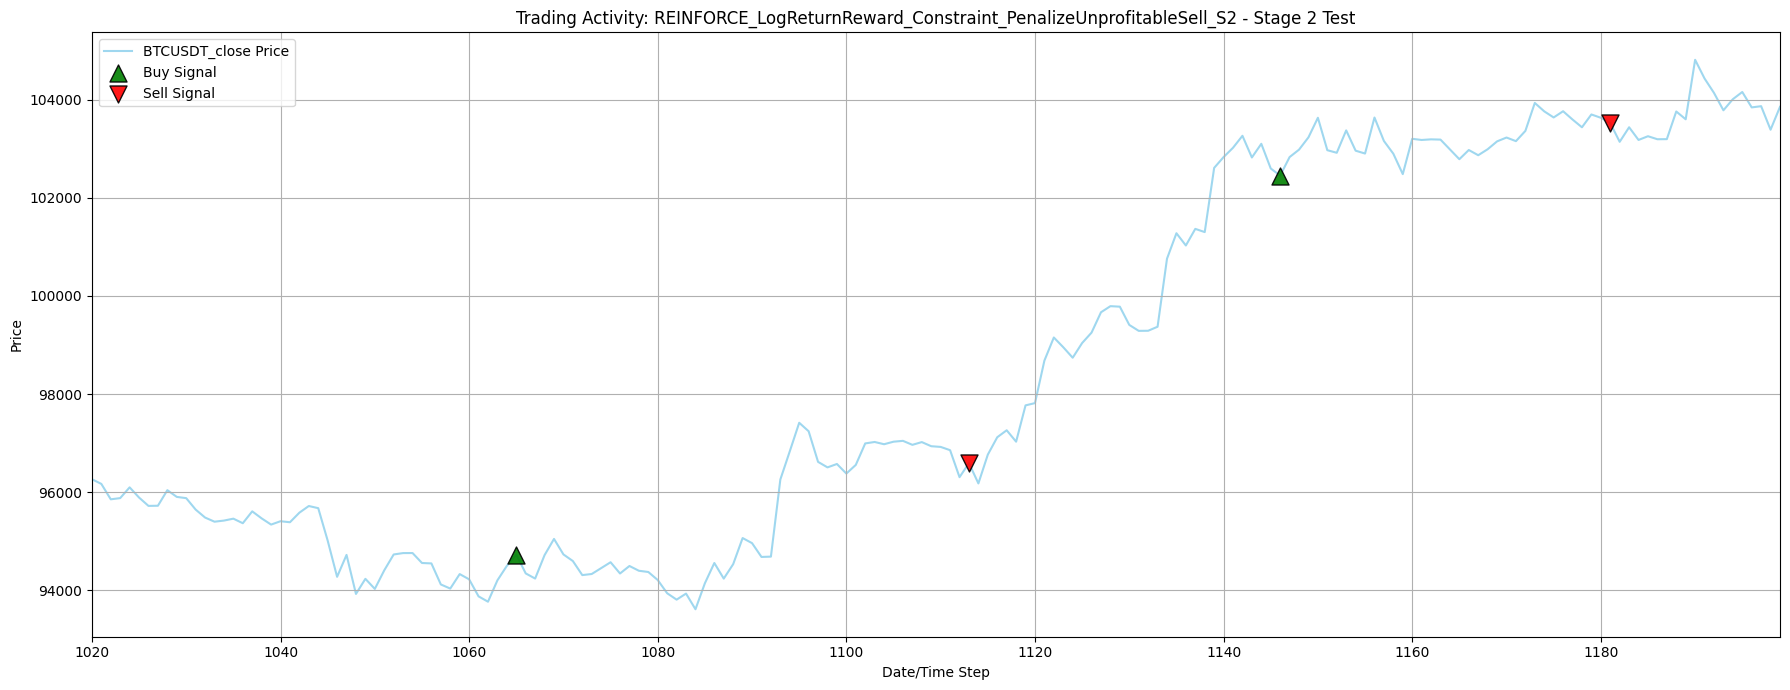

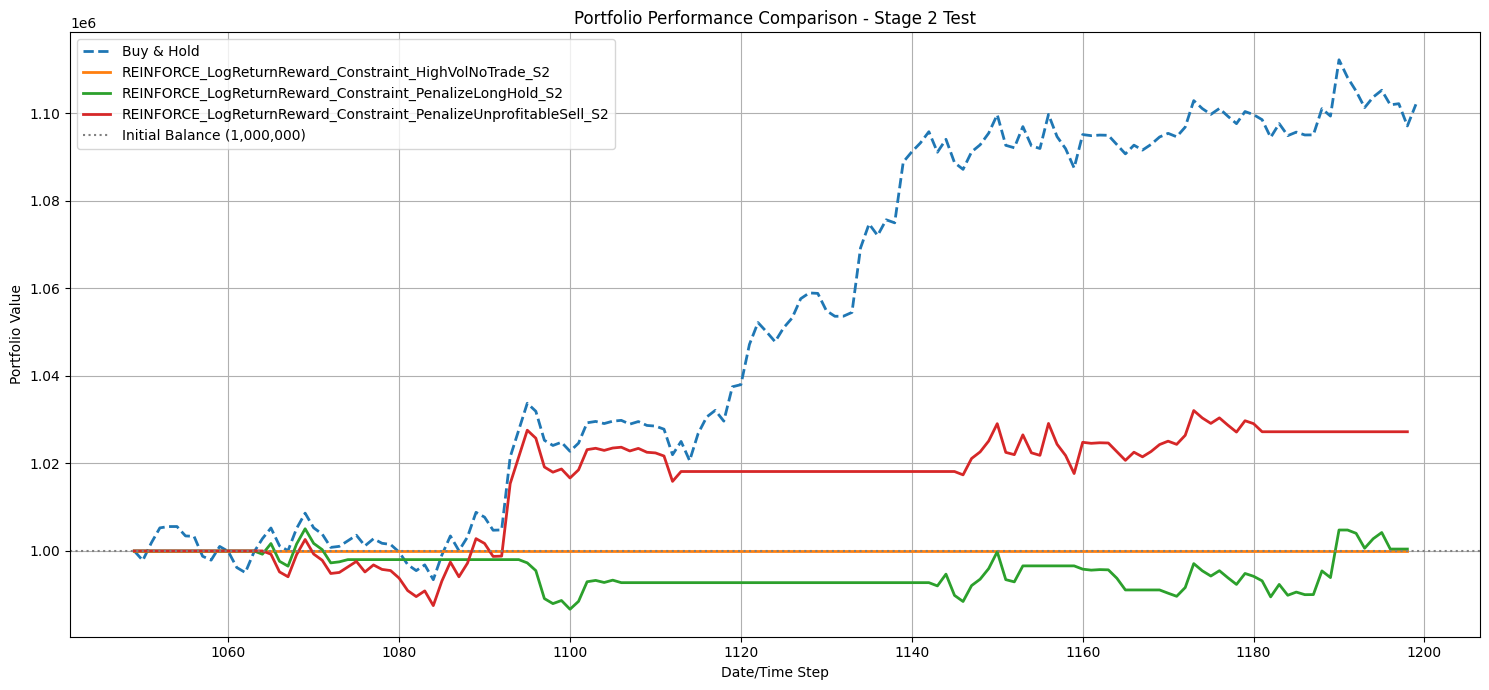



--- STAGE 2 TEST PERFORMANCE SUMMARY ---
                                                                  Final Net Worth  Total Return (%)  Sharpe Ratio (step-wise reward)  Max Drawdown (%)  Number of Trades
Experiment                                                                                                                                                              
Buy & Hold                                                           1102028.7538           10.2029                           0.1737           -1.5072                 2
REINFORCE_LogReturnReward_Constraint_HighVolNoTrade_S2               1000000.0000            0.0000                           0.0000            0.0000                 0
REINFORCE_LogReturnReward_Constraint_PenalizeLongHold_S2             1000425.9513            0.0426                          -0.0014           -1.8293                12
REINFORCE_LogReturnReward_Constraint_PenalizeUnprofitableSell_S2     1027225.3074            2.7225             

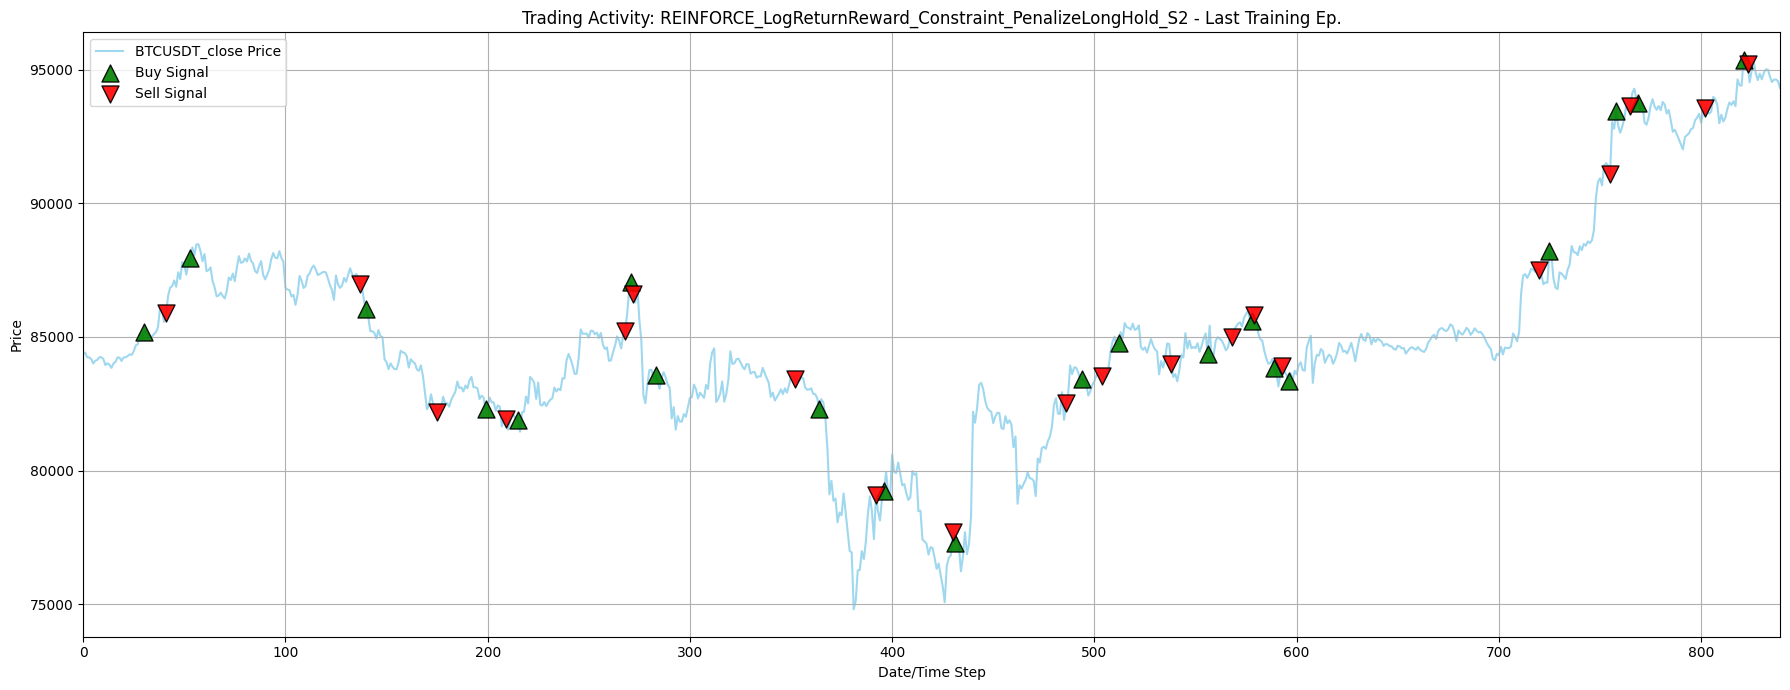

Plotting last training episode trades for: REINFORCE_LogReturnReward_Constraint_PenalizeUnprofitableSell_S2


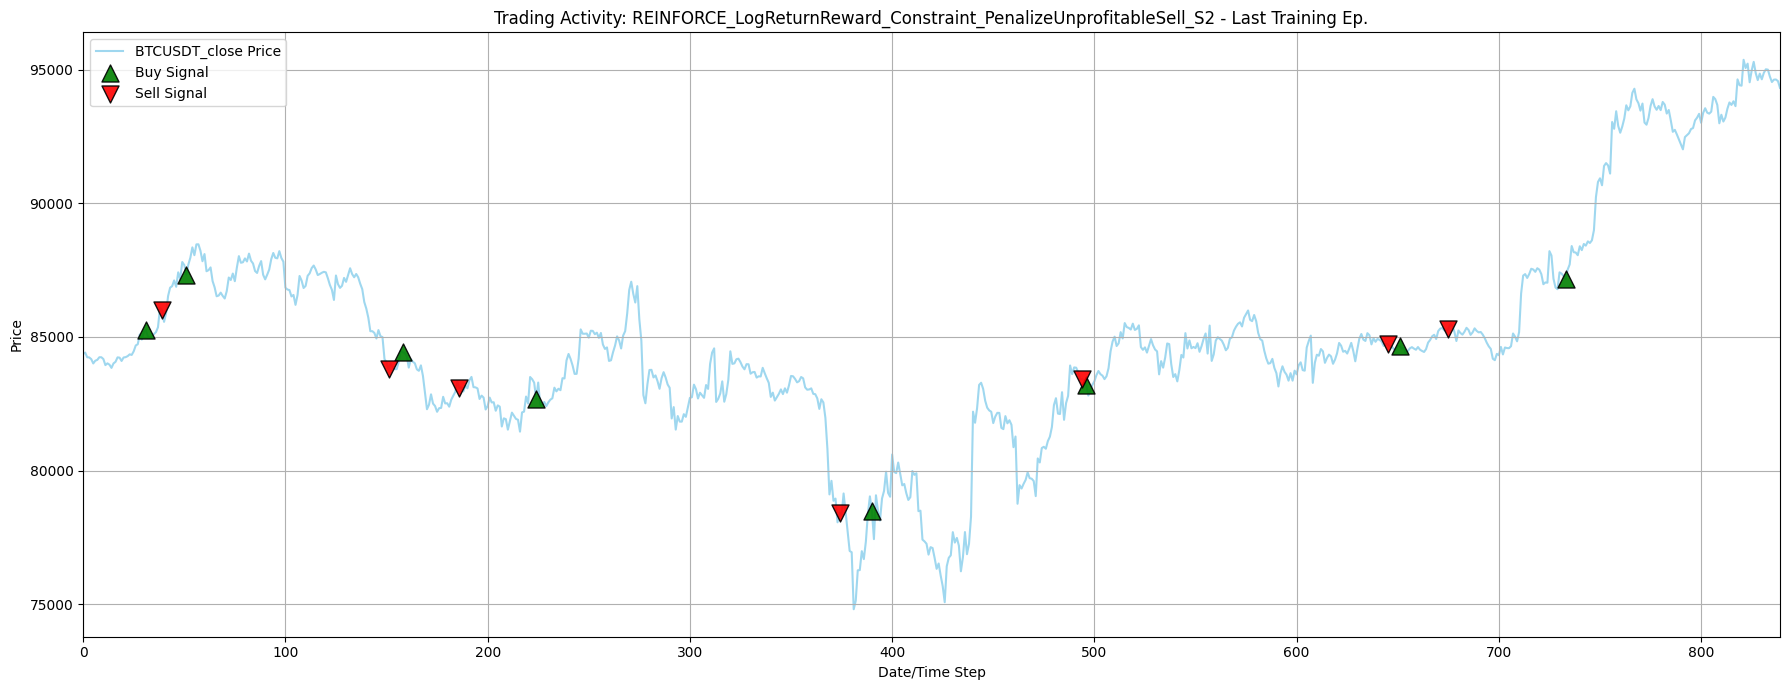

In [11]:


TEST_INITIAL_BALANCE = 1000000.0 


# --- Make sure necessary imports are active ---
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print(f"\n\n{'='*20} STAGE 2 RESULTS EVALUATION {'='*20}")

stage2_test_results_for_plotting = {}
stage2_test_summary_metrics_list = []

# --- Buy and Hold (can often reuse from Stage 1 if test period is the same) ---
# Assuming bh_net_worth_ts_s1 and bh_metrics_dict_s1 are available from Stage 1 eval cell
if 'bh_net_worth_ts_s1' in globals() and 'bh_metrics_dict_s1' in globals():
    stage2_test_results_for_plotting["Buy & Hold"] = {'net_worth_series': bh_net_worth_ts_s1, 'trades': [], 'linestyle': '--'}
    if not any(d['Experiment'] == "Buy & Hold" for d in stage2_test_summary_metrics_list):
        stage2_test_summary_metrics_list.append({"Experiment": "Buy & Hold", **bh_metrics_dict_s1})
else:
    print("Warning: Buy & Hold data from Stage 1 not found, consider recalculating for Stage 2 context if needed.")


# --- Evaluate each trained agent from Stage 2 ---
if 'trained_agents_stage2' in globals() and trained_agents_stage2: # Check if dict exists and is not empty
    # Retrieve the base reward type used for the REINFORCE models in Stage 2
    base_reward_type_for_s2_test = "log_return" # Default
    if 'reinforce_base_config_name_s2' in globals() and reinforce_base_config_name_s2 in stage1_configs:
        base_reward_type_for_s2_test = stage1_configs[reinforce_base_config_name_s2]["reward_type"]
    else:
        print(f"Warning: Base config '{reinforce_base_config_name_s2}' not in stage1_configs. Defaulting reward_type for Stage 2 test envs.")

    for exp_name, agent in trained_agents_stage2.items():
        print(f"\n--- Evaluating Test Performance: {exp_name} ---")
        
        constraint_key_from_name = "NoConstraint_S2Baseline"
        if "_Constraint_" in exp_name:
            constraint_key_from_name = exp_name.split("_Constraint_")[-1]
            
        constraint_params_for_test_env = constraints_to_test_s2.get(constraint_key_from_name)
        if not constraint_params_for_test_env:
            print(f"Warning: Constraint key '{constraint_key_from_name}' for {exp_name} not found in constraints_to_test_s2. Assuming no constraint.")
            constraint_params_for_test_env = {"constraint_type": None}

        test_env_eval = TradingEnv( # Use your working TradingEnv
            test_data,
            window_size=WINDOW_SIZE,
            reward_type=base_reward_type_for_s2_test,
            transaction_cost_pct=TRANSACTION_COST,
            initial_balance=TEST_INITIAL_BALANCE,
            constraint_type=constraint_params_for_test_env.get("constraint_type"),
            volatility_lookback=constraint_params_for_test_env.get("volatility_lookback", 20),
            volatility_threshold_pct=constraint_params_for_test_env.get("volatility_threshold_pct", 0.02),
            DEBUG_MODE=False
        )

        # ======== CALL run_evaluation_and_collect_history HERE ========
        metrics, net_worth_ts, trades = run_evaluation_and_collect_history(
            test_env_eval, agent, test_data
        )
        # =============================================================

        print(f"{exp_name} - Test Metrics:")
        for metric_key, metric_value in metrics.items(): print(f"  {metric_key}: {metric_value:.4f}")

        stage2_test_results_for_plotting[exp_name] = {'net_worth_series': net_worth_ts, 'trades': trades, 'linestyle': '-'}
        stage2_test_summary_metrics_list.append({"Experiment": exp_name, **metrics})

        plot_trades_on_price(exp_name, trades, test_data, title_suffix=" - Stage 2 Test")
        plt.show()
else:
    print("Warning: 'trained_agents_stage2' dictionary not found or empty. Skipping Stage 2 test evaluations.")


# --- Plot combined portfolio performance for Stage 2 Test Results ---
if stage2_test_results_for_plotting: # Check if there's anything to plot
    plot_portfolio_performance(stage2_test_results_for_plotting, TEST_INITIAL_BALANCE, title_suffix=" - Stage 2 Test")
    plt.show()

# --- Print Stage 2 Test Summary Table ---
summary_df_s2 = pd.DataFrame(stage2_test_summary_metrics_list)
if not summary_df_s2.empty:
    print("\n\n--- STAGE 2 TEST PERFORMANCE SUMMARY ---")
    pd.options.display.float_format = '{:.4f}'.format
    print(summary_df_s2.set_index("Experiment").to_string())

# --- Plot Trades for Last Training Episode of Stage 2 Models ---
print("\n\n--- Plotting Trades for Last Training Episode (Stage 2) ---")
if 'last_train_episode_trades_stage2' in globals() and last_train_episode_trades_stage2:
    for config_name, trades in last_train_episode_trades_stage2.items():
        if trades:
            print(f"Plotting last training episode trades for: {config_name}")
            plot_trades_on_price(f"{config_name}", trades, train_data, title_suffix=" - Last Training Ep.")
            plt.show()
        else:
            print(f"No trades recorded in the last training episode for {config_name}.")
else:
    print("Variable 'last_train_episode_trades_stage2' not found/empty. Skipping plots.")